# Machine Learning - Mini Projet
Groupe : Les caissiers de Manor
Membres : Simon Barras, Naël Telfser et Erwan Sturzenegger

# 1. Présentation de l'approche utilisée

Pour ce projet, nous partons d'un dataset de production solaire contenant 15 champs utiles afin de faire des prédictions
sur la production solaire à un instant T.

Nous avons choisi de faire une approche de type "regression" afin de prédire cette production solaire.

La démarche est la suivante:
1. Exploration des données
2. Choix des champs à utiliser
3. Nettoyage des données et préprocessing
4. Choix du modèle et comparaison des résultats
5. Choix du modèle final et prédictions
6. Postprocessing des résultats
7. Conclusion

__Attention__ : ceci est un __résumé__ de notre méthode. Pour des raisons évidentes de place et de temps de rédaction, tous les tests ne sont pas présentés mais seulement la version que nous avons finalement décidée de prendre.

# 2. Exploration des données
## 2.1. Import des librairies

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

## 2.2. Import des données

In [40]:
df = pd.read_csv('./dataset/training.csv')

## 2.3 Exploration et visualisation

In [41]:
print(df.head())
df.info()
df.describe()

   index                 Date       temp  humidity  precip  snow  snowdepth  \
0      0  2022-07-27 02:00:00  21.277778     51.52     0.0   0.0        0.0   
1      1  2022-07-27 02:05:00  21.277778     51.52     0.0   0.0        0.0   
2      2  2022-07-27 02:10:00  21.277778     51.52     0.0   0.0        0.0   
3      3  2022-07-27 02:15:00  21.277778     51.52     0.0   0.0        0.0   
4      4  2022-07-27 02:20:00  21.277778     51.52     0.0   0.0        0.0   

   windspeed  winddir  visibility  cloudcover  solarradiation  solarenergy  \
0        7.8      3.0        21.7         9.5            33.0          0.1   
1        7.8      3.0        21.7         9.5            33.0          0.1   
2        7.8      3.0        21.7         9.5            33.0          0.1   
3        7.8      3.0        21.7         9.5            33.0          0.1   
4        7.8      3.0        21.7         9.5            33.0          0.1   

   uvindex conditions  solar_production  
0      0.0    

,index,temp,humidity,precip,snow,snowdepth,windspeed,winddir,visibility,cloudcover,solarradiation,solarenergy,uvindex,solar_production
count,17856.000000,17264.000000,17264.000000,17264.000000,17264.0,17264.0,17264.000000,17264.000000,9588.000000,17264.000000,9468.000000,9336.000000,9468.000000,17856.000000
mean,8927.500000,17.589383,67.190304,0.006200,0.0,0.0,5.193119,184.106881,8.790363,27.955955,312.998733,1.144087,3.081115,0.602949
std,5154.727539,4.725173,16.617836,0.022904,0.0,0.0,3.006230,124.391423,5.680712,36.385981,293.696892,1.056423,2.984444,0.918450
min,0.000000,4.944444,25.830000,0.000000,0.0,0.0,0.000000,0.000000,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4463.750000,14.444444,54.540000,0.000000,0.0,0.0,3.000000,50.000000,6.200000,0.000000,39.000000,0.200000,0.000000,0.000000
50%,8927.500000,17.500000,68.520000,0.000000,0.0,0.0,4.600000,220.600000,6.200000,2.400000,211.000000,0.800000,2.000000,0.012093
75%,13391.250000,20.666667,80.210000,0.000000,0.0,0.0,6.800000,300.000000,6.200000,54.800000,568.000000,2.100000,6.000000,0.970219
max,17855.000000,32.055556,97.010000,0.370000,0.0,0.0,18.300000,360.000000,34.200000,100.000000,1076.000000,3.900000,10.000000,3.306164


Il en ressort deux choses :
- Certains champs (Date et conditions) devront être transformés en nombre afin d'être mieux analysés
- Le dataset contient 17856 entrées

Afin de voir à quoi ressemble la courbe de production de quelques journées, nous allons prendre 5 jours avec un interval équivalent entre chacun d'eux et afficher toutes les données heures par heures.

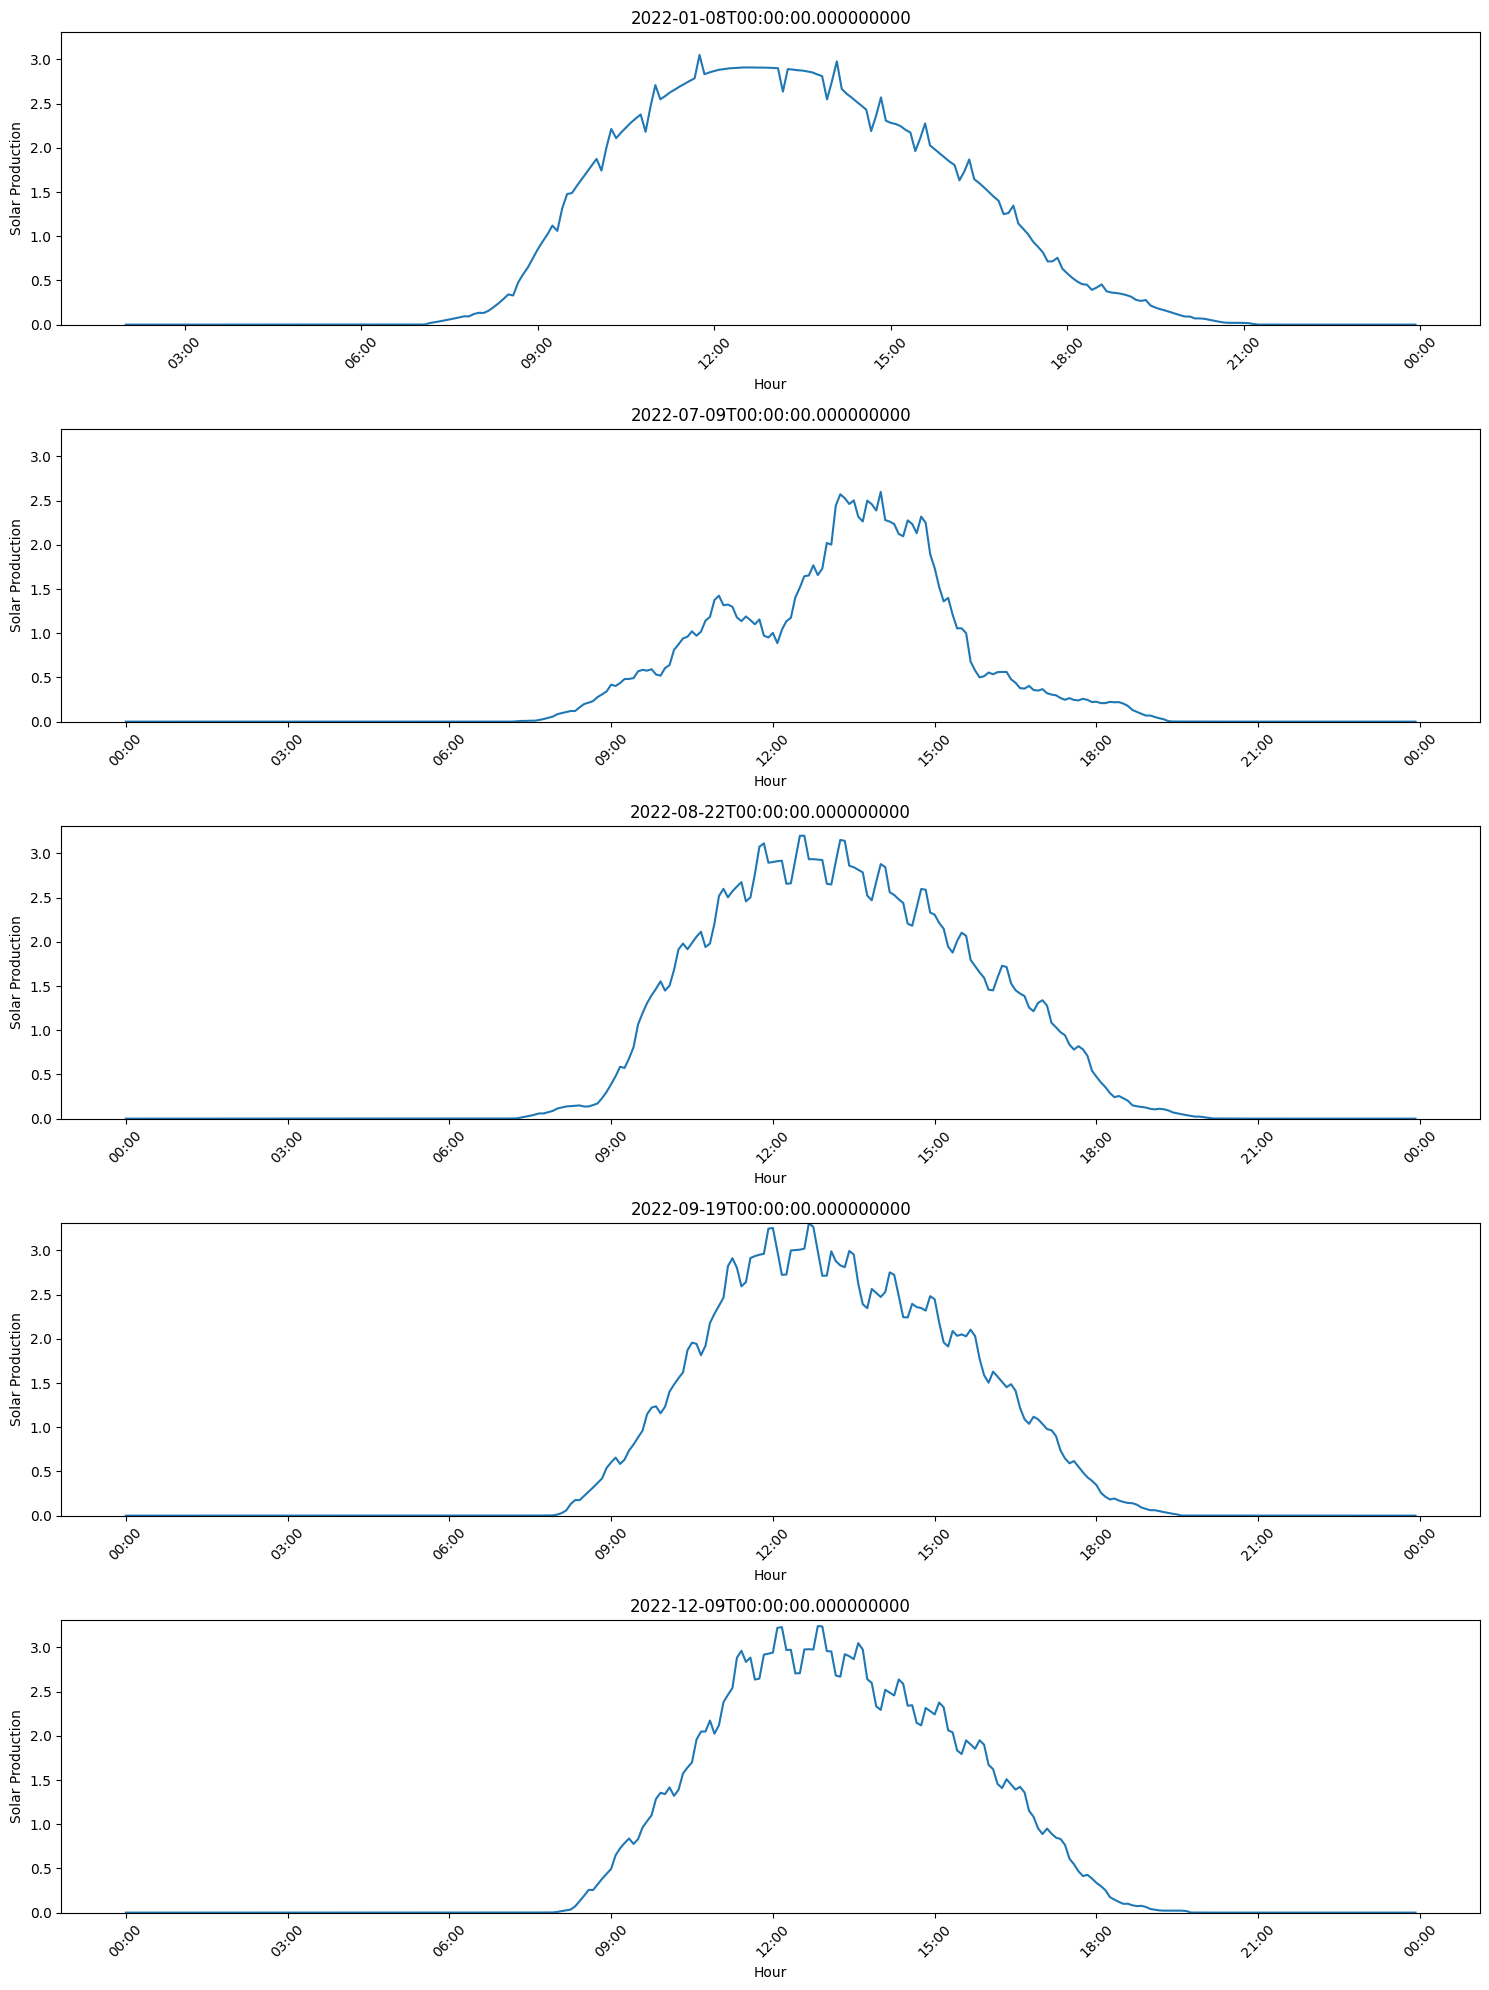

In [42]:
df['Date'] = pd.to_datetime(df['Date'])

days = df['Date'].dt.floor('d').unique()
days = np.sort(days)

# Compute number of days
n_days = len(days)
# Compute spacing between days
space = n_days//4
days_to_plot = days[::space]

# Plotting the data for the 5 days, hour by hour with solar_production on the y-axis and hour on the x-axis
fig, ax = plt.subplots(5, 1, figsize=(15, 20))
y_max = 0
for i, day in enumerate(days_to_plot):
    df_day = df[df['Date'].dt.floor('d') == day]
    ax[i].plot(df_day['Date'], df_day['solar_production'])
    ax[i].set_title(day)
    ax[i].set_ylabel('Solar Production')
    ax[i].set_xlabel('Hour')
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # Rotate 45 degrees
    plt.setp(ax[i].get_xticklabels(), rotation=45)
    # Set y_max
    if df_day['solar_production'].max() > y_max:
        y_max = df_day['solar_production'].max()

# Set plot on same scale
ax[0].set_ylim([0, y_max])
ax[1].set_ylim([0, y_max])
ax[2].set_ylim([0, y_max])
ax[3].set_ylim([0, y_max])
ax[4].set_ylim([0, y_max])

plt.tight_layout()
plt.show()

# 3. Choix des champs à utiliser

Pour choisir les champs utiles, nous avons fait une analyse avec SelectKBest afin de voir les champs les plus pertinents.
Nous avons aussi ajouté l'heure car nous trouvons que c'est un champ important pour la prédiction. L'index a été supprimé car non pertinent.

## 3.1. SelectKBest

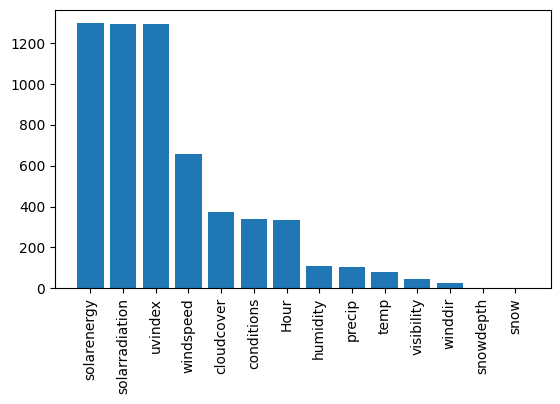

In [43]:
# Copie du dataframe
df_features = df.drop(columns=['index'])

# Ajout de l'heure car c'est un facteur important à nos yeux
df_features['Hour'] = df_features['Date'].dt.hour
df_features = df_features.drop(columns=['Date'])
# Suppression des lignes avec des valeurs manquantes pour la production solaire s'il y en a
df_features.dropna(subset=['solar_production'], inplace=True)

# Convert string to int with label encoding
df_features[['conditions']] = df_features[['conditions']].fillna('UNKNOWN')  # Fill nan value with unknown

# Remplacement des valeurs manquantes par 0
df_features.fillna(0, inplace=True)

# Transformation des données catégorielles en données numériques
cats = pd.Categorical(df_features.conditions)
df_features['conditions'] = cats.codes

# Sélectionner toutes les colonnes, à l'exception de la cible
X = df_features.drop(columns=['solar_production'])
# Sélectionner la colonne cible
y = df_features['solar_production']

# Utiliser la régression linéaire pour sélectionner les 14 caractéristiques les plus pertinentes (toutes)
selector = SelectKBest(score_func=f_regression, k=14)
selector.fit(X, y)

# Récupérer le score de chaque caractéristique
scores = selector.scores_

# Récupérer le nom de chaque caractéristique
selected_columns = X.columns[selector.get_support()]

# Afficher les caractéristiques et leurs scores en ordre décroissant
sorted_scores = np.sort(scores)[::-1]
sorted_names = [selected_columns[i] for i in np.argsort(scores)[::-1]]
plt.bar([i for i in range(len(sorted_scores))], sorted_scores)
plt.xticks([i for i in range(len(sorted_names))], sorted_names, rotation='vertical')
plt.subplots_adjust(bottom=0.3)
plt.show()

Les champs qui sont certains d'être utilisés sont :
- solarenergy
- solarradiation
- uvindex

Certains champs nous paraissent suspects: par exemple, windspeed qui est nommés dans les 4 meilleures features à utiliser...

Certain champs sont éliminés d'offices tels que :
- snowdepth et snow qui ne contiennent aucunes données
- winddir, temp, precip et visibility qui n'apporte que peu d'informations

Les autres champs seront employés ou pas en fonction du nettoyage des données plus tard.

# 4. Nettoyage des données et preprocessing

Pour la préparation des données nous avons prévu de :
- Supprimer les colonnes inutiles
- Transformer les champs en valeur numériques
- Mettre des 0 partout où des données manquent
- D'appliquer le minmax scaler pour avoir des données (hors production) entre 0 et 1.
    - Fusion des datasets d'entraînement et final pour avoir un scaler qui prend tout en compte
    - Une fois normalisés, les datasets seront à nouveau séparés

In [47]:
COLUMN_NAMES = {'index', 'Date', 'temp', 'humidity', 'precip', 'snow', 'snowdepth', 'windspeed', 'winddir',
                'visibility', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex', 'conditions'}
SELECTED_FEATURES = {'Date', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'hour'}

def clean_normalize(df, finalDf):
    df['Date'] = pd.to_datetime(df['Date'])
    to_drop = list(COLUMN_NAMES.difference(SELECTED_FEATURES))
    df = df.drop(columns=to_drop)

    # Combiner les deux dataset pour avoir les mêmes colonnes
    finalDf['Date'] = pd.to_datetime(finalDf['Date'], format='%Y-%d-%m %H:%M:%S')
    finalDf = finalDf.drop(columns=to_drop)

    # Ajouter des productions négatives pour le dataset final
    finalDf['solar_production'] = -100
    # Combine the two dataframes
    df = pd.concat([df, finalDf], ignore_index=True)
    # Rebuild index
    df = df.reset_index(drop=True)

    # Convert Date to hour and month colums
    df['hour'] = df['Date'].dt.hour

    # Drop date column
    df = df.drop(columns=['Date'])

    # Fill conditions na with "UNKNOWN"
    df['conditions'] = df['conditions'].fillna('UNKNOWN')
    # Fill na with 0
    df = df.fillna(0)

    # Transform literals to numbers
    df['conditions'] = df['conditions'].map(
        {
            'UNKNOWN': 0,
            'Rain, Partially cloudy': 2,
            'Rain': 3,
            'Overcast': 4,
            'Rain, Overcast': 1,
            'Partially cloudy': 5,
            'Clear': 6,
        })

    # Keep production
    prod = df['solar_production']
    df = df.drop(columns=['solar_production'])

    # Normalize the data with minimax
    df = (df - df.min()) / (df.max() - df.min())

    # Add production back
    df['solar_production'] = prod

    # Separate df from finalDf

    finalDf = df[df['solar_production'] <= -100]
    finalDf = finalDf.drop(columns=['solar_production'])
    df = df[df['solar_production'] > -100]
    return df, finalDf

finalDf = pd.read_csv('./dataset/test_students.csv')
df_cleaned, final_cleaned = clean_normalize(df, finalDf)

print(df_cleaned.head())

   cloudcover  solarradiation  solarenergy  uvindex  conditions      hour  \
0       0.095        0.030669     0.025641      0.0         1.0  0.086957   
1       0.095        0.030669     0.025641      0.0         1.0  0.086957   
2       0.095        0.030669     0.025641      0.0         1.0  0.086957   
3       0.095        0.030669     0.025641      0.0         1.0  0.086957   
4       0.095        0.030669     0.025641      0.0         1.0  0.086957   

   solar_production  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  


# 5. Choix du modèle et comparaison des résultats

Nous avons choisi de faire une recherche aléatoire sur les hyperparamètres afin de trouver le meilleur modèle.

Les estimateurs utilisés sont les suivants:
- SVR
- RandomForestRegressor
- GradientBoostingRegressor
- KNeighborsRegressor

Nous avons aussi testé d'autres estimateurs mais, soit le temps pour l'entraînement était __TRÈS__ long, soit les résultats étaient mauvais :
- MLPRegressor
- AdaBoostRegressor

Pour des raisons de temps de calculs, nous n'utiliserons pas les méthodes ci-dessous mais nous avons mis directement les paramètres optimaux trouvés pour chaque estimateur.

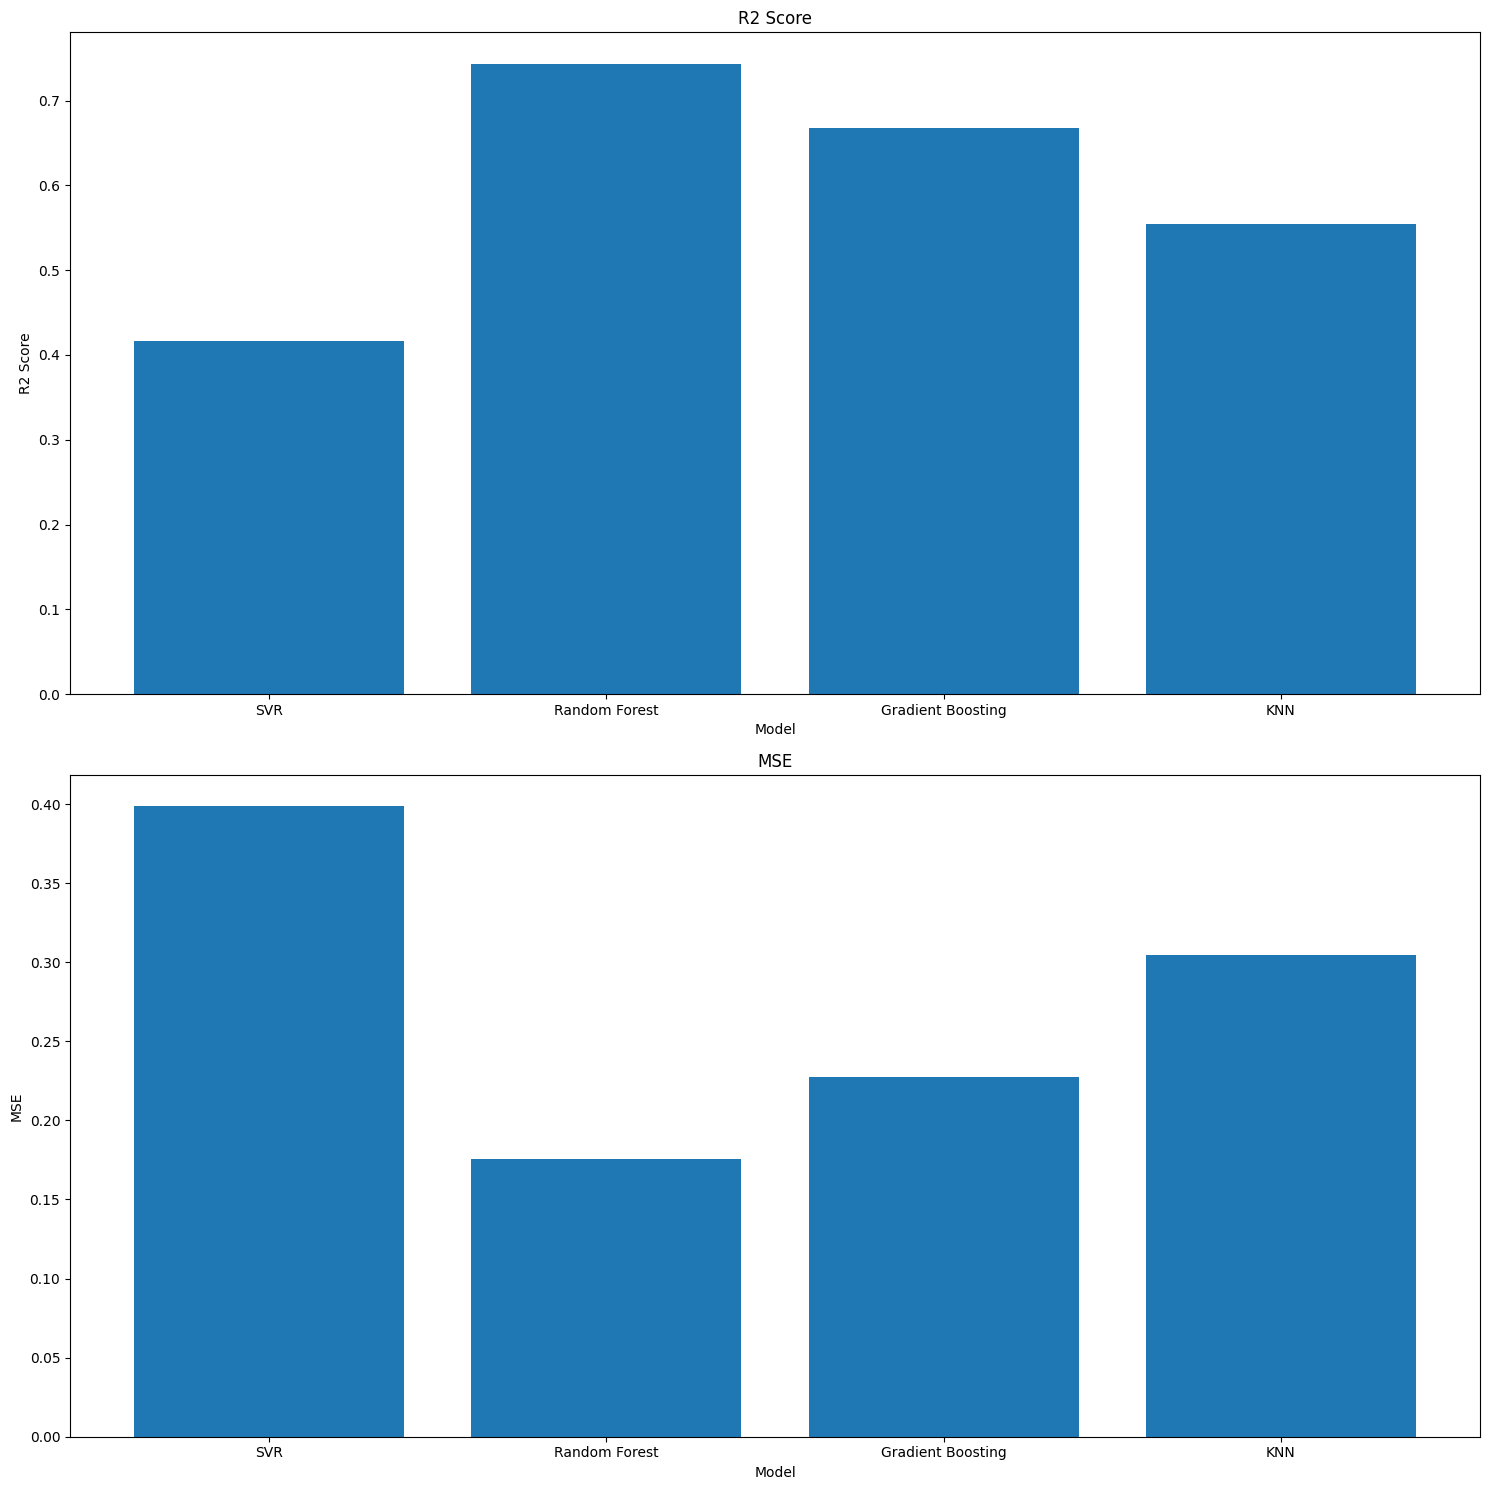

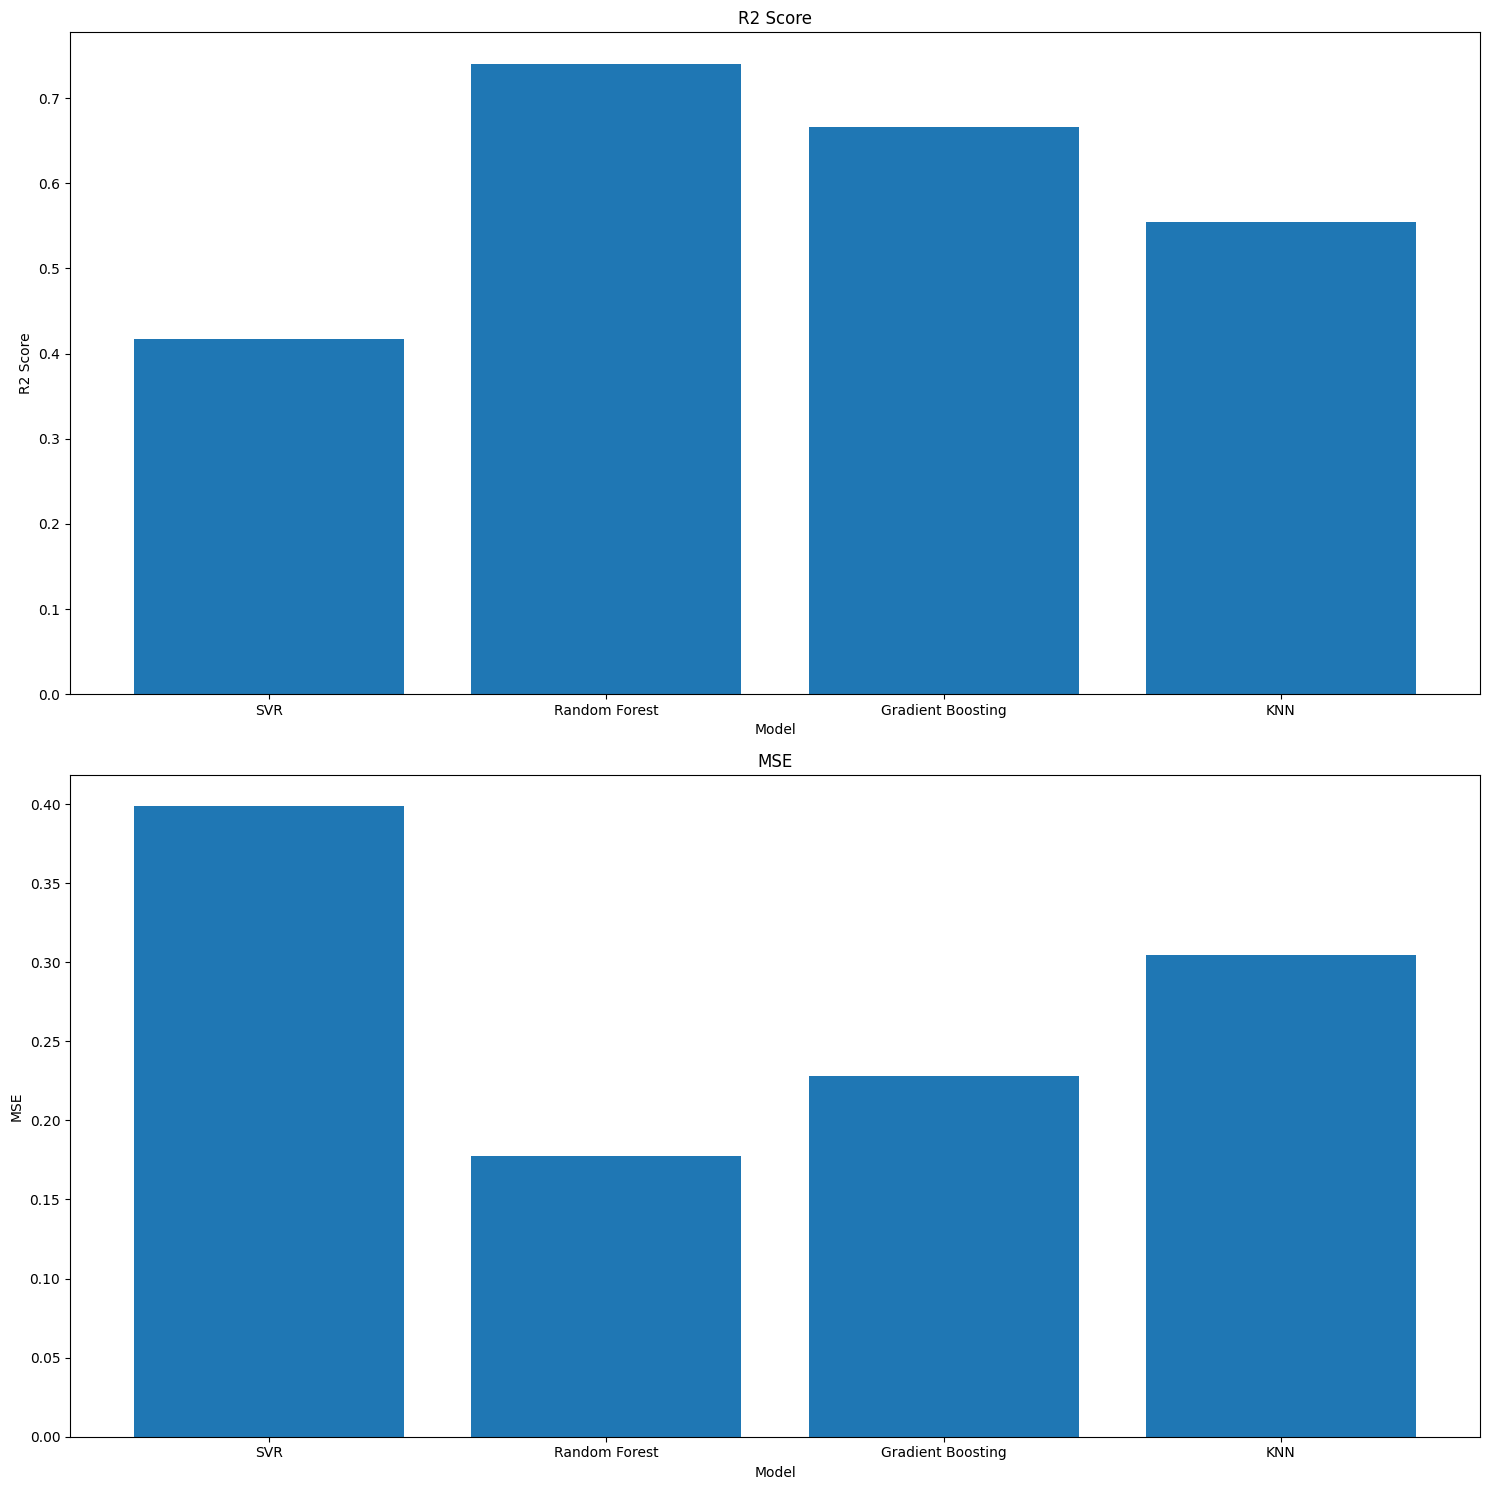

In [49]:

def train_svr(X_train, y_train):
    svr = SVR()

    # Hyperparameters
    params = {
        'kernel': ['rbf'],
        'C': [1, 10, 100, 1000],
        'gamma': ['scale', 0.001, 0.0001, 0.01, 0.1],
        'epsilon': [1/x for x in range(1, 100, 10)]
    }

    # RandomizedSearchCV
    svr_random = RandomizedSearchCV(estimator=svr, param_distributions=params, n_iter=300, cv=5, verbose=2, random_state=42, n_jobs=-1)
    svr_random.fit(X_train, y_train)
    print("Best parameters for SVR: ", svr_random.best_params_)
    print("Best score for SVR: ", svr_random.best_score_)
    return svr_random.best_estimator_

def train_rf(X_train, y_train):
    rf = RandomForestRegressor()

    # Hyperparameters
    params = {
        'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
        'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
        'min_samples_split': [x for x in range(2, 30)],
        'min_samples_leaf': [x for x in range(1, 30)]
    }

    # RandomizedSearchCV
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=300, cv=5, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)
    print("Best parameters for RF: ", rf_random.best_params_)
    print("Best score for RF: ", rf_random.best_score_)
    return rf_random.best_estimator_

def train_gb(X_train, y_train):
    gb = GradientBoostingRegressor()

    # Hyperparameters
    params = {
        'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
        'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
        'min_samples_split': [x for x in range(2, 30)],
        'min_samples_leaf': [x for x in range(1, 30)]
    }

    # RandomizedSearchCV
    gb_random = RandomizedSearchCV(estimator=gb, param_distributions=params, n_iter=300, cv=5, verbose=2, random_state=42, n_jobs=-1)
    gb_random.fit(X_train, y_train)
    print("Best parameters for GB: ", gb_random.best_params_)
    print("Best score for GB: ", gb_random.best_score_)
    return gb_random.best_estimator_

def train_knn(X_train, y_train):
    knn = KNeighborsRegressor()

    # Hyperparameters
    params = {
        'n_neighbors': [x for x in range(1, 30)],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [x for x in range(1, 50)],
        'p': [x for x in range(1, 10)]
    }

    # RandomizedSearchCV
    knn_random = RandomizedSearchCV(estimator=knn, param_distributions=params, n_iter=300, cv=5, verbose=2, random_state=42, n_jobs=-1)
    knn_random.fit(X_train, y_train)
    print("Best parameters for KNN: ", knn_random.best_params_)
    print("Best score for KNN: ", knn_random.best_score_)
    return knn_random.best_estimator_

def train_and_compare(df):
    # Split data
    X = df.drop(columns=['solar_production'])
    y = df['solar_production']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

    # Train models and plot results


    # svr_regressor = train_svr(X_train, y_train)
    # =>   Best params are {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.09090909090909091, 'C': 10}
    svr_regressor = SVR(**{'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.09090909090909091, 'C': 10})
    svr_regressor.fit(X_train, y_train)
    svr_y_pred = svr_regressor.predict(X_test)


    # rf_regressor = train_rf(X_train, y_train)
    # =>   Best params are {'n_estimators': 600, 'min_samples_split': 13, 'min_samples_leaf': 27, 'max_depth': 10}
    rf_regressor = RandomForestRegressor(**{'n_estimators': 600, 'min_samples_split': 13, 'min_samples_leaf': 27, 'max_depth': 10})
    rf_regressor.fit(X_train, y_train)
    rf_y_pred = rf_regressor.predict(X_test)


    # gb_regressor = train_gb(X_train, y_train)
    # =>   Best params are  {'n_estimators': 200, 'min_samples_split': 29, 'min_samples_leaf': 29, 'max_depth': 10}
    gb_regressor = GradientBoostingRegressor(**{'n_estimators': 200, 'min_samples_split': 29, 'min_samples_leaf': 29, 'max_depth': 10})
    gb_regressor.fit(X_train, y_train)
    gb_y_pred = gb_regressor.predict(X_test)


    # knn_regressor = train_knn
    # =>   Best params are {'weights': 'uniform', 'p': 8, 'n_neighbors': 29, 'leaf_size': 47, 'algorithm': 'kd_tree'}
    knn_regressor = KNeighborsRegressor(**{'weights': 'uniform', 'p': 8, 'n_neighbors': 29, 'leaf_size': 47, 'algorithm': 'kd_tree'})
    knn_regressor.fit(X_train, y_train)
    knn_y_pred = knn_regressor.predict(X_test)

    # Calculate R2 score et MSE
    svr_r2 = r2_score(y_test, svr_y_pred)
    svr_mse = mean_squared_error(y_test, svr_y_pred)
    rf_r2 = r2_score(y_test, rf_y_pred)
    rf_mse = mean_squared_error(y_test, rf_y_pred)
    gb_r2 = r2_score(y_test, gb_y_pred)
    gb_mse = mean_squared_error(y_test, gb_y_pred)
    knn_r2 = r2_score(y_test, knn_y_pred)
    knn_mse = mean_squared_error(y_test, knn_y_pred)

    # Garder une trace des résultats (c'est long à exécuter)
    with open("results.txt", "w") as f:
        f.write("SVR: R2 = {}, MSE = {}\n".format(svr_r2, svr_mse))
        f.write("RF: R2 = {}, MSE = {}\n".format(rf_r2, rf_mse))
        f.write("GB: R2 = {}, MSE = {}\n".format(gb_r2, gb_mse))
        f.write("KNN: R2 = {}, MSE = {}\n".format(knn_r2, knn_mse))

    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(15, 15))
    ax[0].bar(['SVR', 'Random Forest', 'Gradient Boosting', 'KNN'], [svr_r2, rf_r2, gb_r2, knn_r2])
    ax[0].set_title('R2 Score')
    ax[0].set_ylabel('R2 Score')
    ax[0].set_xlabel('Model')

    ax[1].bar(['SVR', 'Random Forest', 'Gradient Boosting', 'KNN'], [svr_mse, rf_mse, gb_mse, knn_mse])
    ax[1].set_title('MSE')
    ax[1].set_ylabel('MSE')
    ax[1].set_xlabel('Model')
    plt.tight_layout()
    plt.show()


train_and_compare(df_cleaned)

# 6. Choix du modèle final et prédictions
Au vu des résultats ci-dessus, on voit que la RandomForest obtient un R2 score bien meilleur ainsi qu'un MSE plus bas que les autres.

Le subset de test n'est pas pris aléatoirement dans le dataset mais ce sont le 20 premiers pourcents de celui-ci. Aucune de ces lignes n'a été utilisée pour l'entraînement. Au début, notre erreur a été de prendre le subset de manière aléatoire mais les résultats montraient que les estimateurs étaient très overfittés et que lors de la prédiction finale, les résultats étaient très mauvais (0.16 avec le R2 score).

Maintenant que l'estimateur est connu, il est temps de tuner les hyperparamètres afin d'obtenir le meilleur modèle possible. Nous avons donc fait une recherche aléatoire sur les hyperparamètres afin de trouver le meilleur modèle qui optimise le R2 score et minimise le MSE.

Il faudra aussi appliquer un postprocessing afin d'améliorer les résultats mais ce sera dans un second temps.

In [50]:
def train_random_forest():
    df = pd.read_csv('./dataset/training.csv')
    finalDf = pd.read_csv('./dataset/test_students.csv')

    df, finalDf = clean_normalize(df, finalDf)

    # Split the data into test and train set (80% train, 20% test)
    X, y = df.drop(columns=['solar_production']), df['solar_production']

    # Get 40% of row every where in the dataset as train set and delete them from the dataset
    X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.8, shuffle=False)

    # Create a random forest classifier
    clf = RandomForestRegressor()

    params = {
        'max_depth': [int(x) for x in np.linspace(start=5, stop=1000, num=100)],
        'min_samples_leaf': [int(x) for x in range(1, 50)],
        'min_samples_split': [int(x) for x in range(1, 50)],
        'n_estimators': [int(x) for x in np.linspace(start=200, stop=5000, num=50)]
    }

    number_of_fits = params['max_depth'].__len__() * params['min_samples_leaf'].__len__() * params[
        'min_samples_split'].__len__() * params['n_estimators'].__len__()
    print('Number of fits: {}, with 5 folds, {}'.format(number_of_fits, str(number_of_fits * 5)))

    # Train the classifier
    random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=2000, cv=10, verbose=2, random_state=42,
                                       n_jobs=-1, scoring='r2')
    random_search.fit(X_train, y_train)

    # Print the best parameters
    print(random_search.best_params_)

    # Print the best score
    print(random_search.best_score_)

    # Save estimator
    import pickle
    pickle.dump(random_search.best_estimator_, open('./models/best-estimator-rf.pkl', 'wb'))

    # Test on test data
    y_pred = random_search.predict(X_test)

    # R2 score
    print("R2 score: ", r2_score(y_test, y_pred))

    # MSE
    print("MSE: ", mean_squared_error(y_test, y_pred))

Le résultat est le suivant après 14 heures de calculation :
> {'n_estimators': 200, 'min_samples_split': 26, 'min_samples_leaf': 48, 'max_depth': 507}
> 0.6412454536746195
> R2 score:  0.8259874964031028
> MSE:  0.16892103539478023

Pour des raisons de temps, voici une fonction qui permet de prendre directement le meilleur estimateur.

In [57]:
def train_random_forest_short():
    df = pd.read_csv('./dataset/training.csv')
    finalDf = pd.read_csv('./dataset/test_students.csv')

    df, finalDf = clean_normalize(df, finalDf)

    # Split the data into test and train set (80% train, 20% test)
    X, y = df.drop(columns=['solar_production']), df['solar_production']

    # Get 40% of row every where in the dataset as train set and delete them from the dataset
    X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.8, shuffle=False)

    # Create a random forest classifier
    clf = RandomForestRegressor(**{'n_estimators': 200, 'min_samples_split': 26, 'min_samples_leaf': 48, 'max_depth': 507})
    clf.fit(X_train, y_train)

    # Predict the test set
    y_pred = clf.predict(X_test)


    # Calculate R2 score et MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("R2 = {}, MSE = {}".format(r2, mse))

    return clf

estimator = train_random_forest_short()

R2 = 0.8261684365314497, MSE = 0.16874538943145545


Comparaison des données réelles et des données prédites

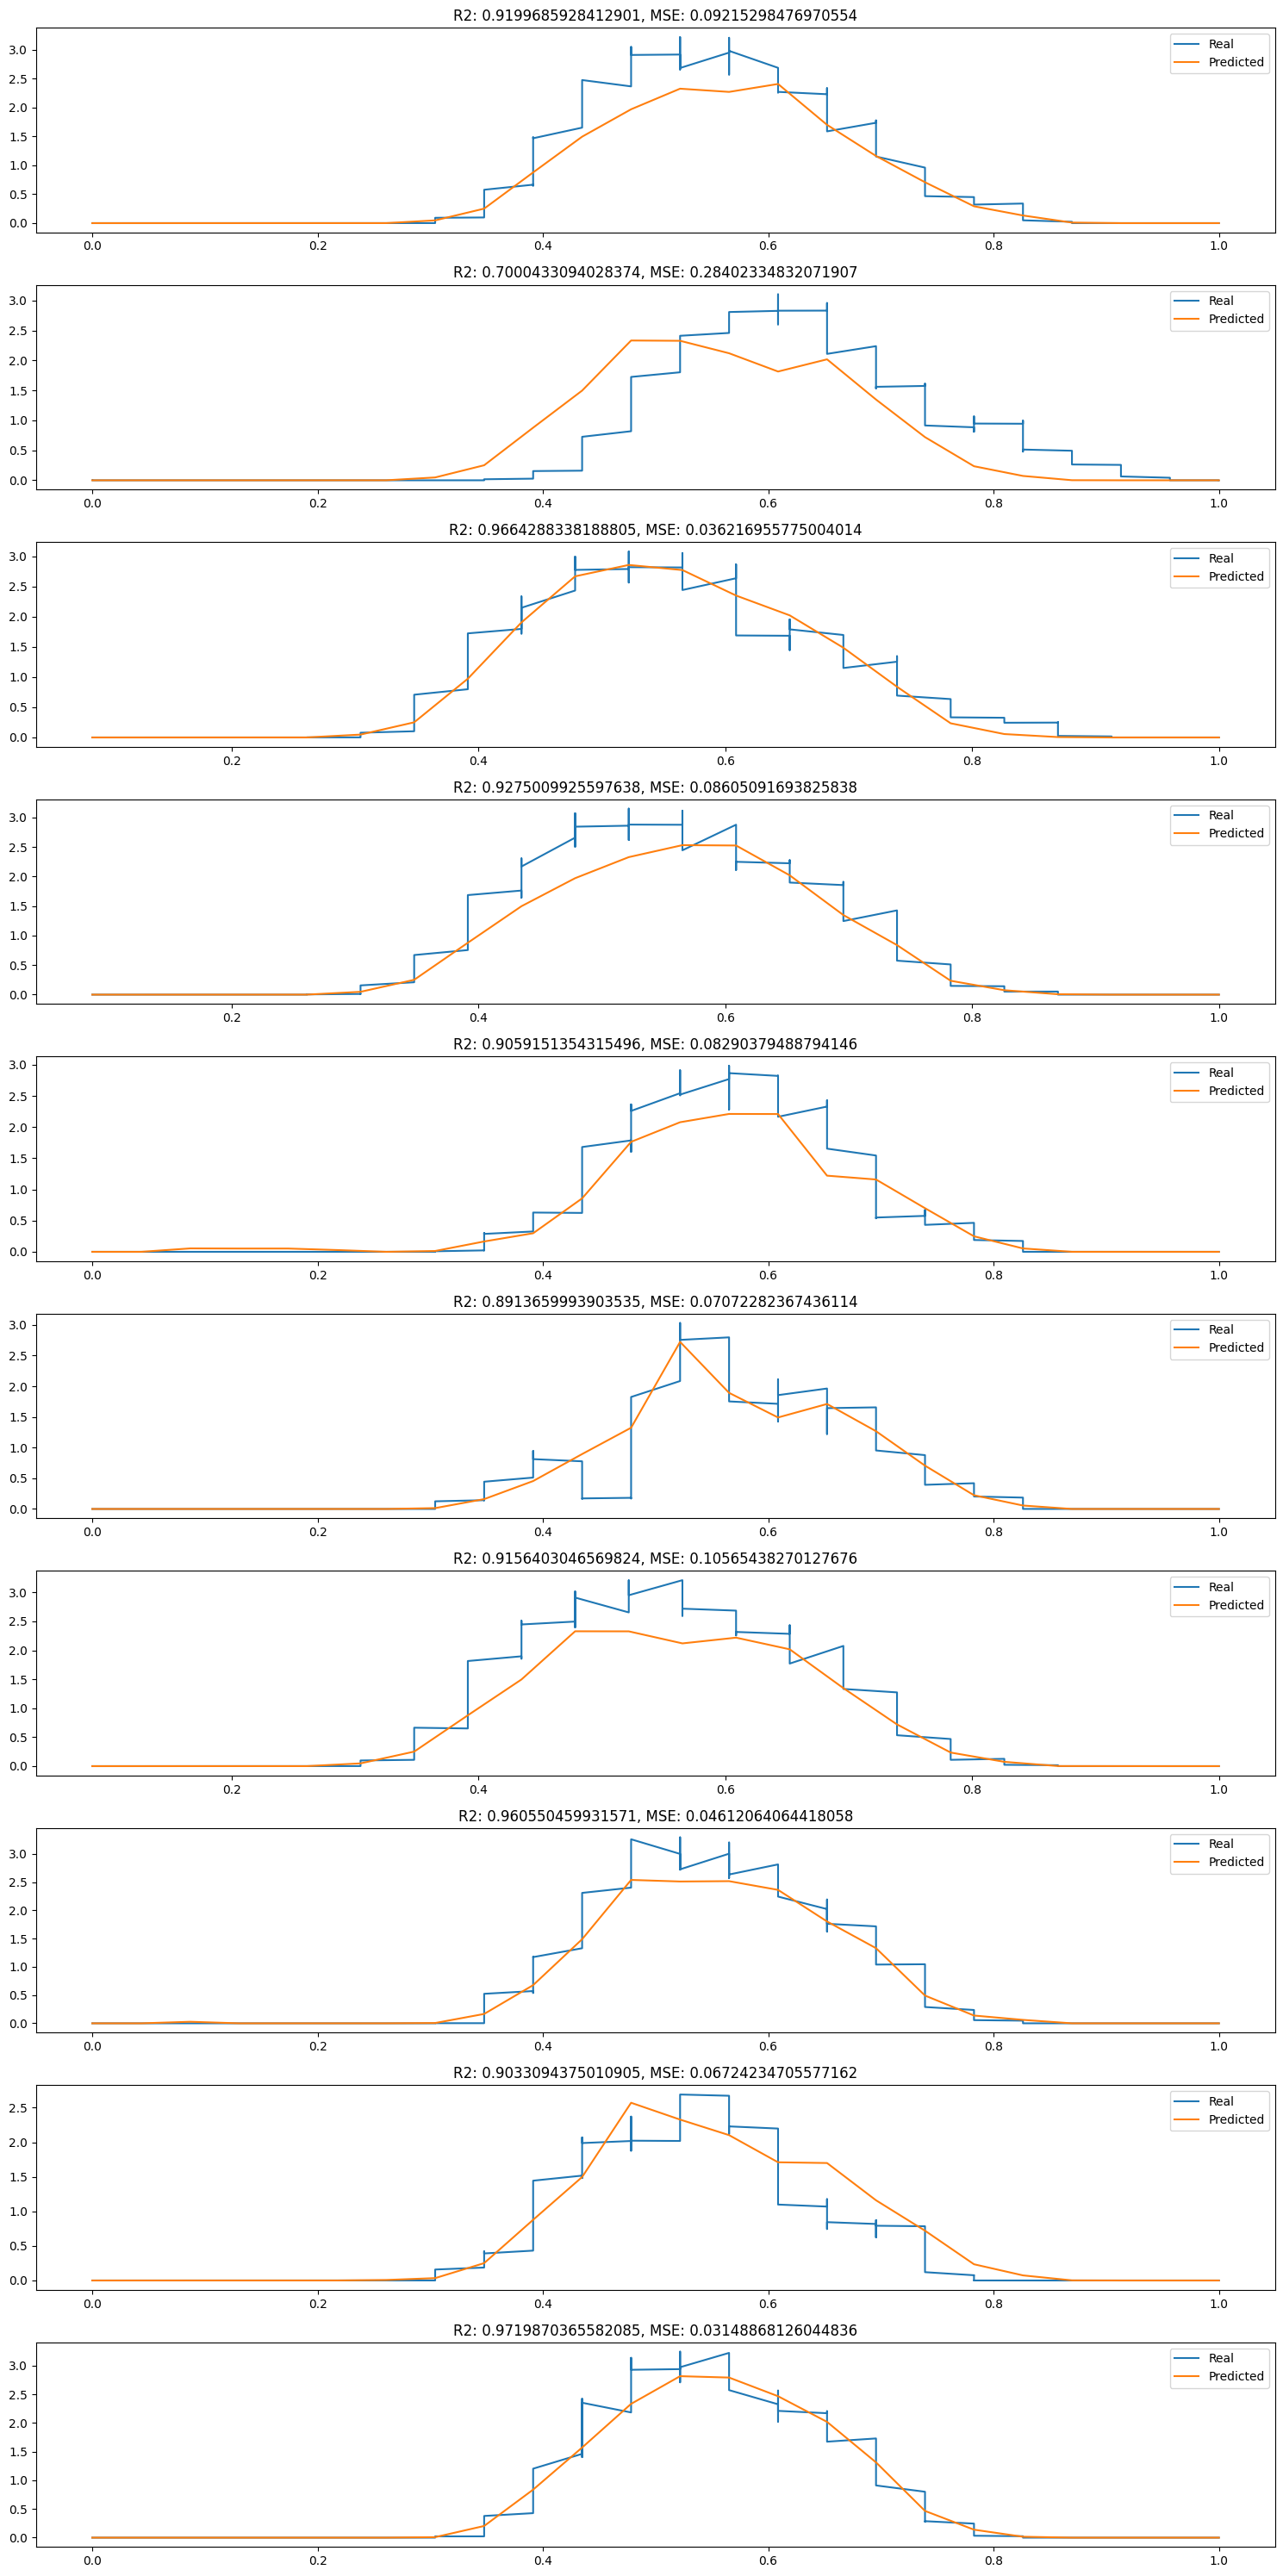

In [58]:
def compare_real_and_predicted(estimator):
    df = pd.read_csv('./dataset/training.csv')
    finalDf = pd.read_csv('./dataset/test_students.csv')

    df_cleaned, finalDf = clean_normalize(df, finalDf)



    unique_days = df['Date'].dt.floor('d').unique()

    # 10 randoms days
    random_days = np.random.choice(unique_days, 10, replace=False)
    unique_days = np.setdiff1d(unique_days, random_days)

    # Create a figure with 10 subplots
    fig, axs = plt.subplots(10, 1, figsize=(15, 30))
    index = 0
    for day in random_days:
        indexes = df['Date'].dt.floor('d') == day

        if df[indexes].shape[0] < 250:
            while df[indexes].shape[0] < 250:
                day = np.random.choice(unique_days, 1, replace=False)[0]
                unique_days = np.setdiff1d(unique_days, day)
                indexes = df['Date'].dt.floor('d') == day

        df_day = df_cleaned[indexes]
        X, y = df_day.drop(columns=['solar_production']), df_day['solar_production']

        y_pred = estimator.predict(X)

        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)

        axs[index].plot(X['hour'], y, label='Real')
        axs[index].plot(X['hour'], y_pred, label='Predicted')
        axs[index].set_title('R2: {}, MSE: {}'.format(r2, mse))
        axs[index].legend()
        index += 1

    plt.tight_layout()
    plt.show()



compare_real_and_predicted(estimator)

Globalement, les résultats sont plutôt bons même s'il y a de grosses erreurs de temps en temps.

# Post traitement et visualisation des résultats

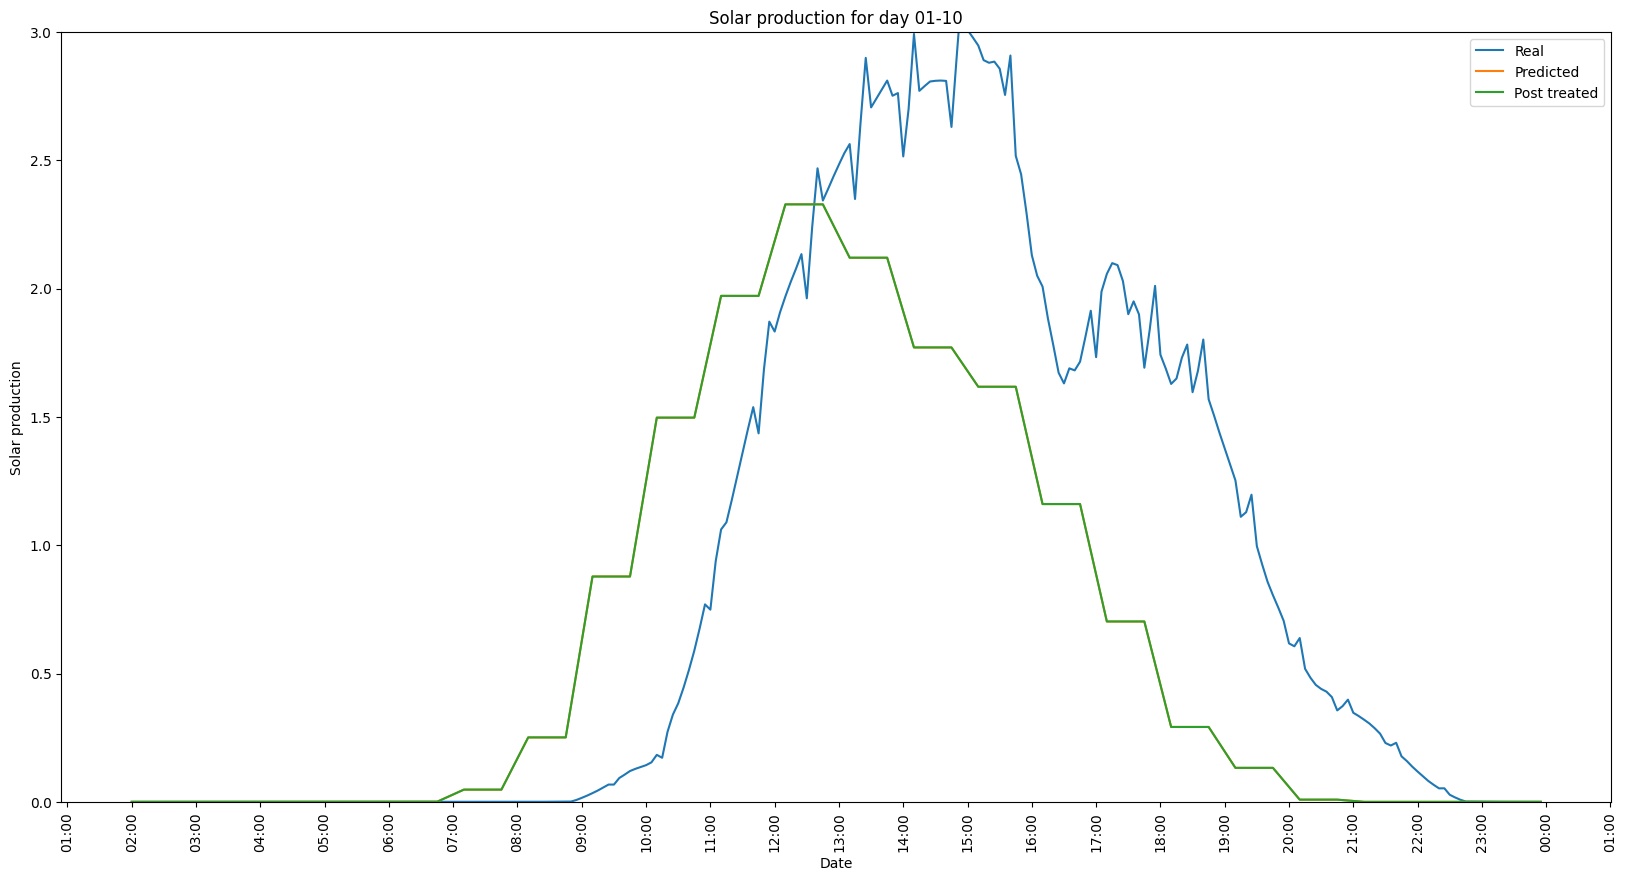

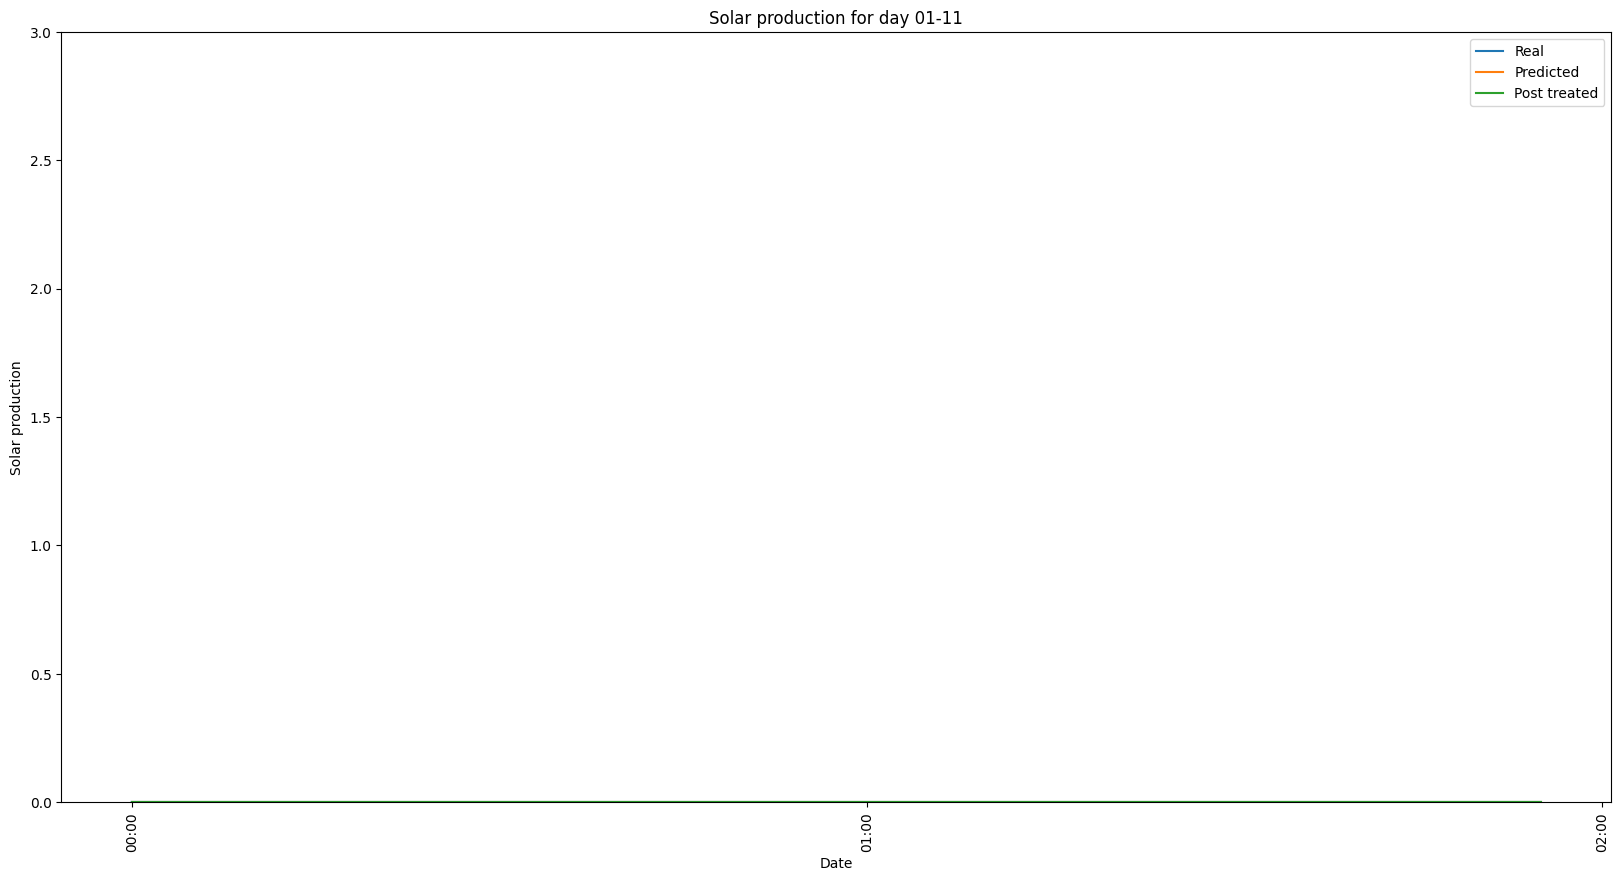

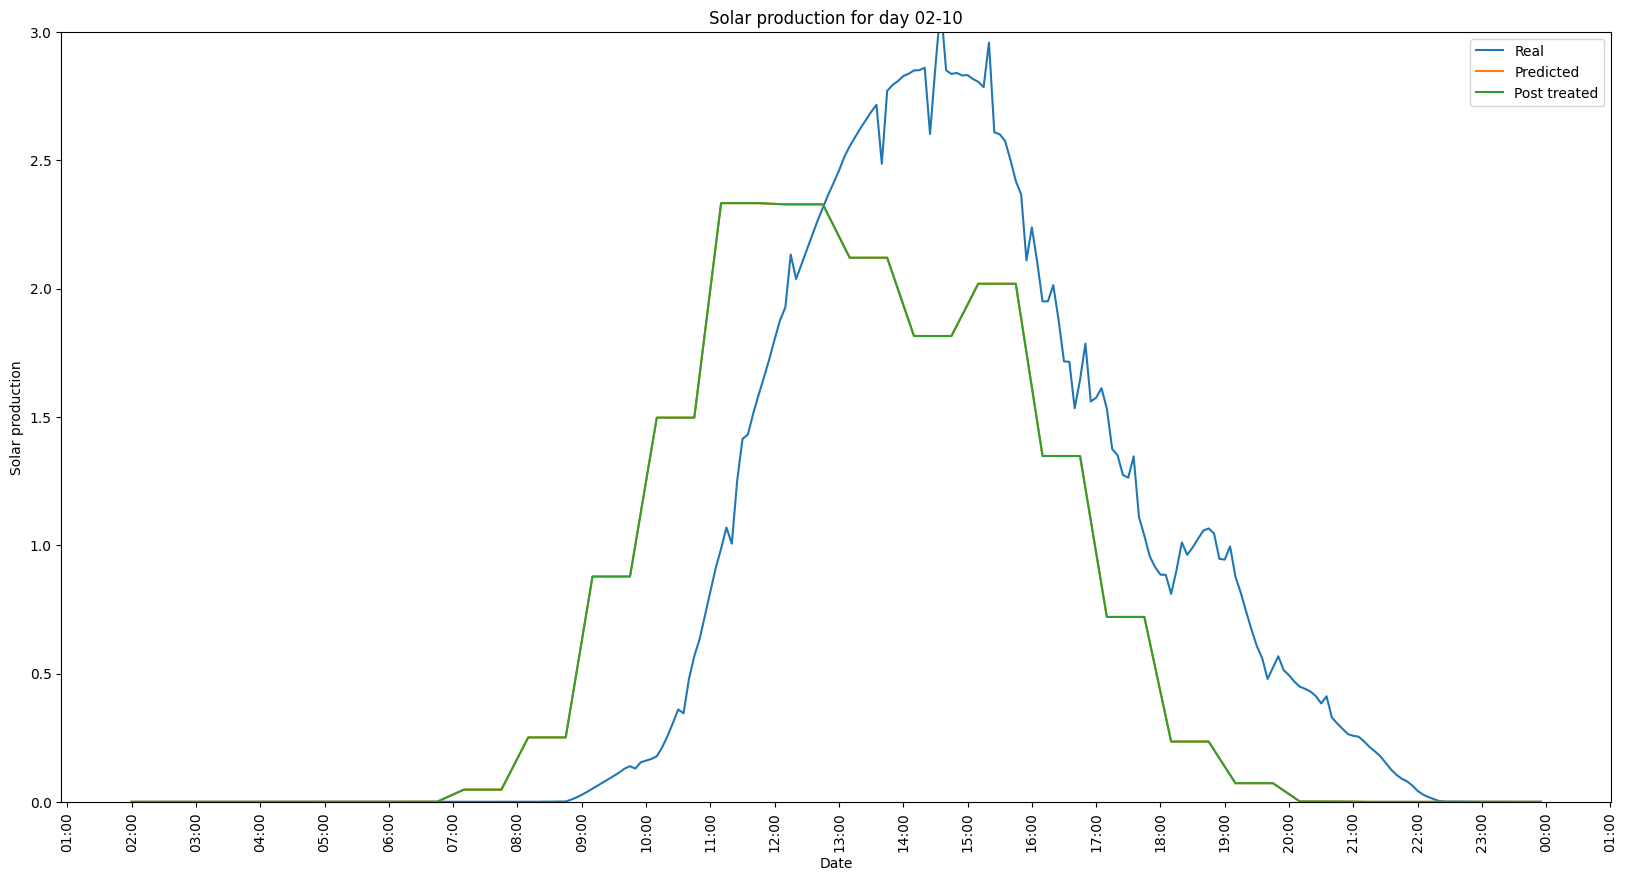

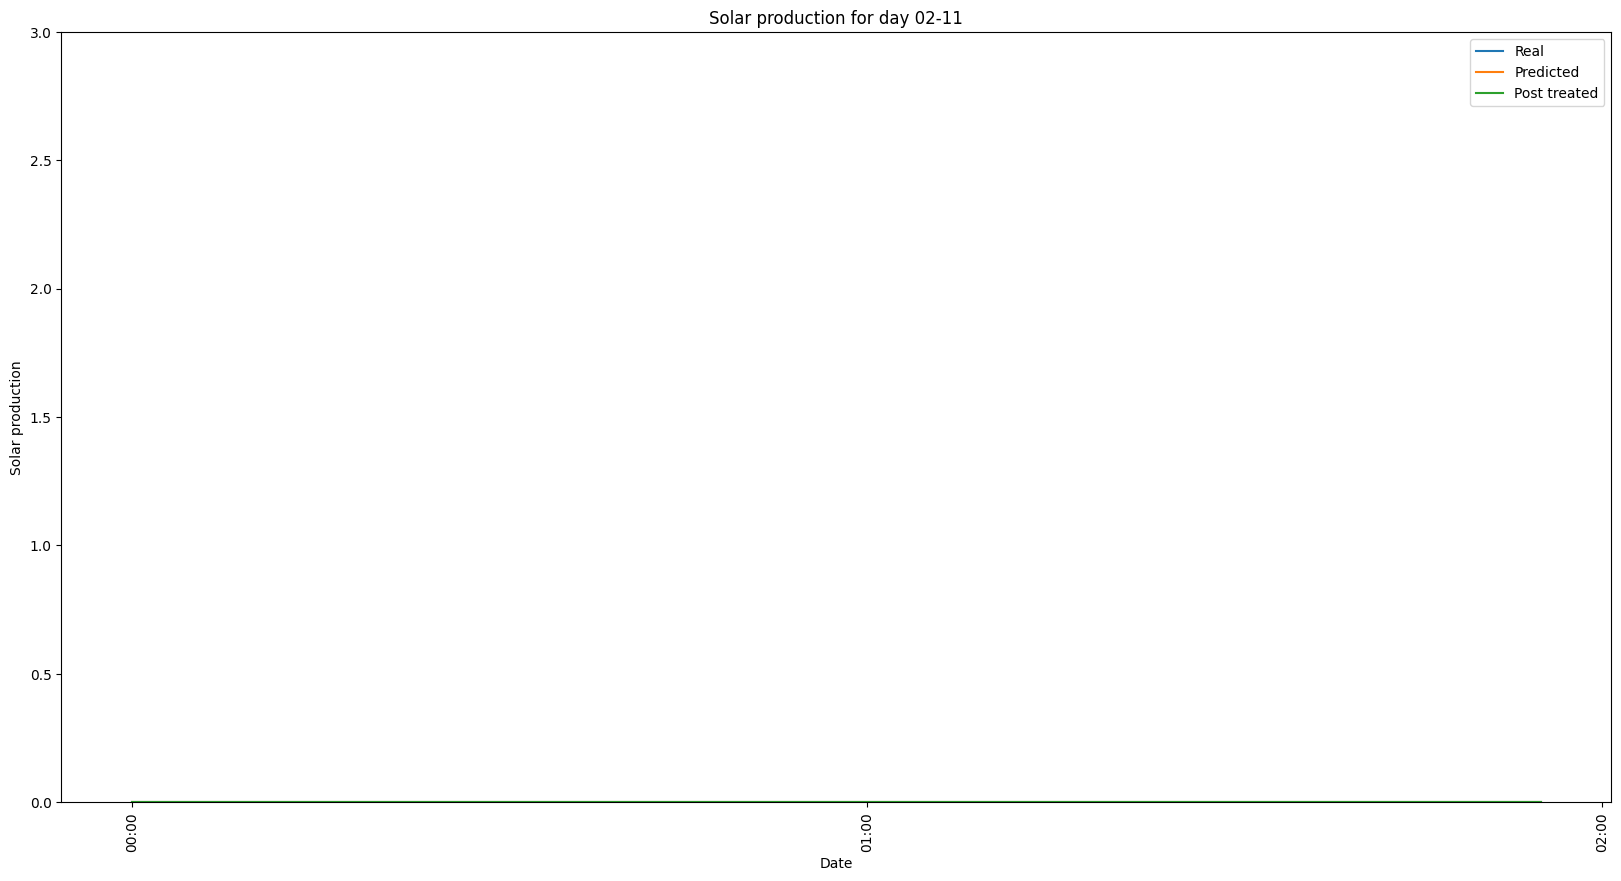

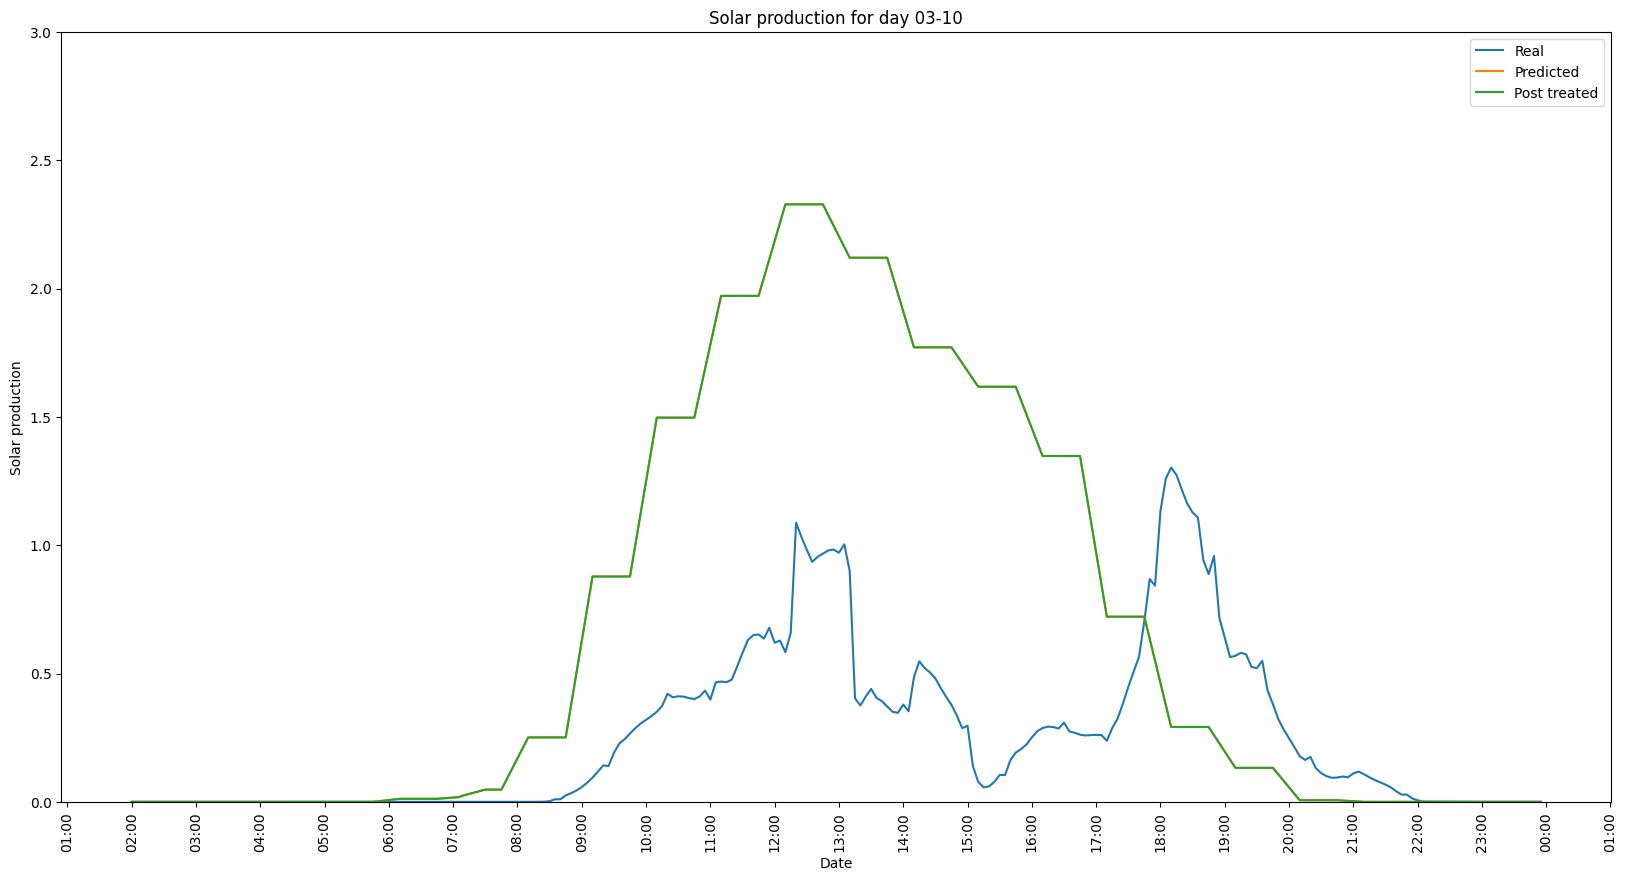

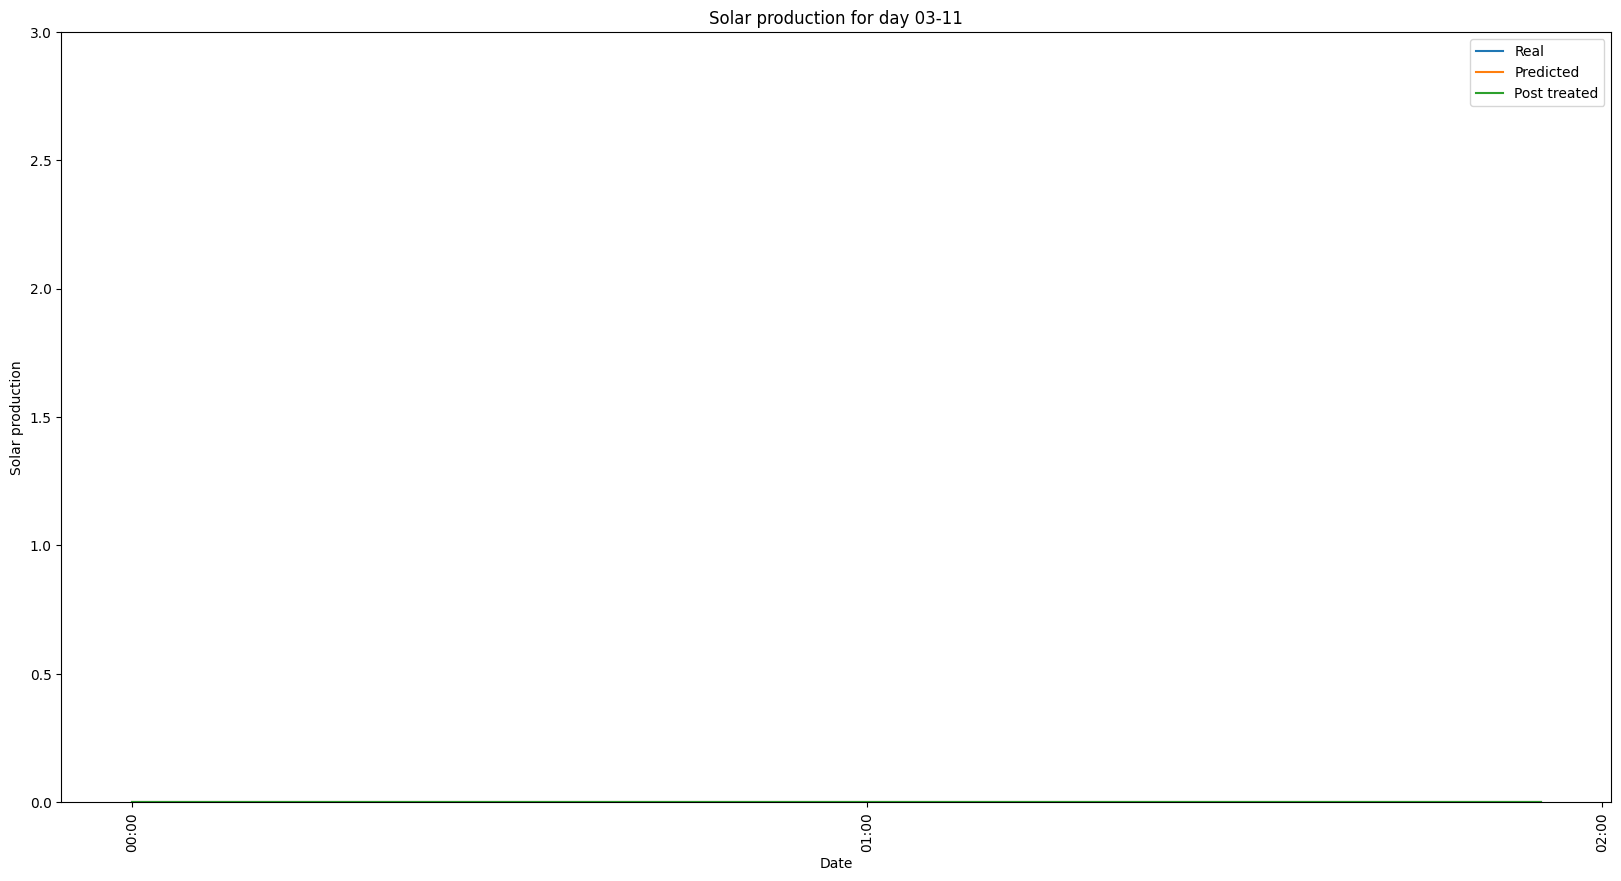

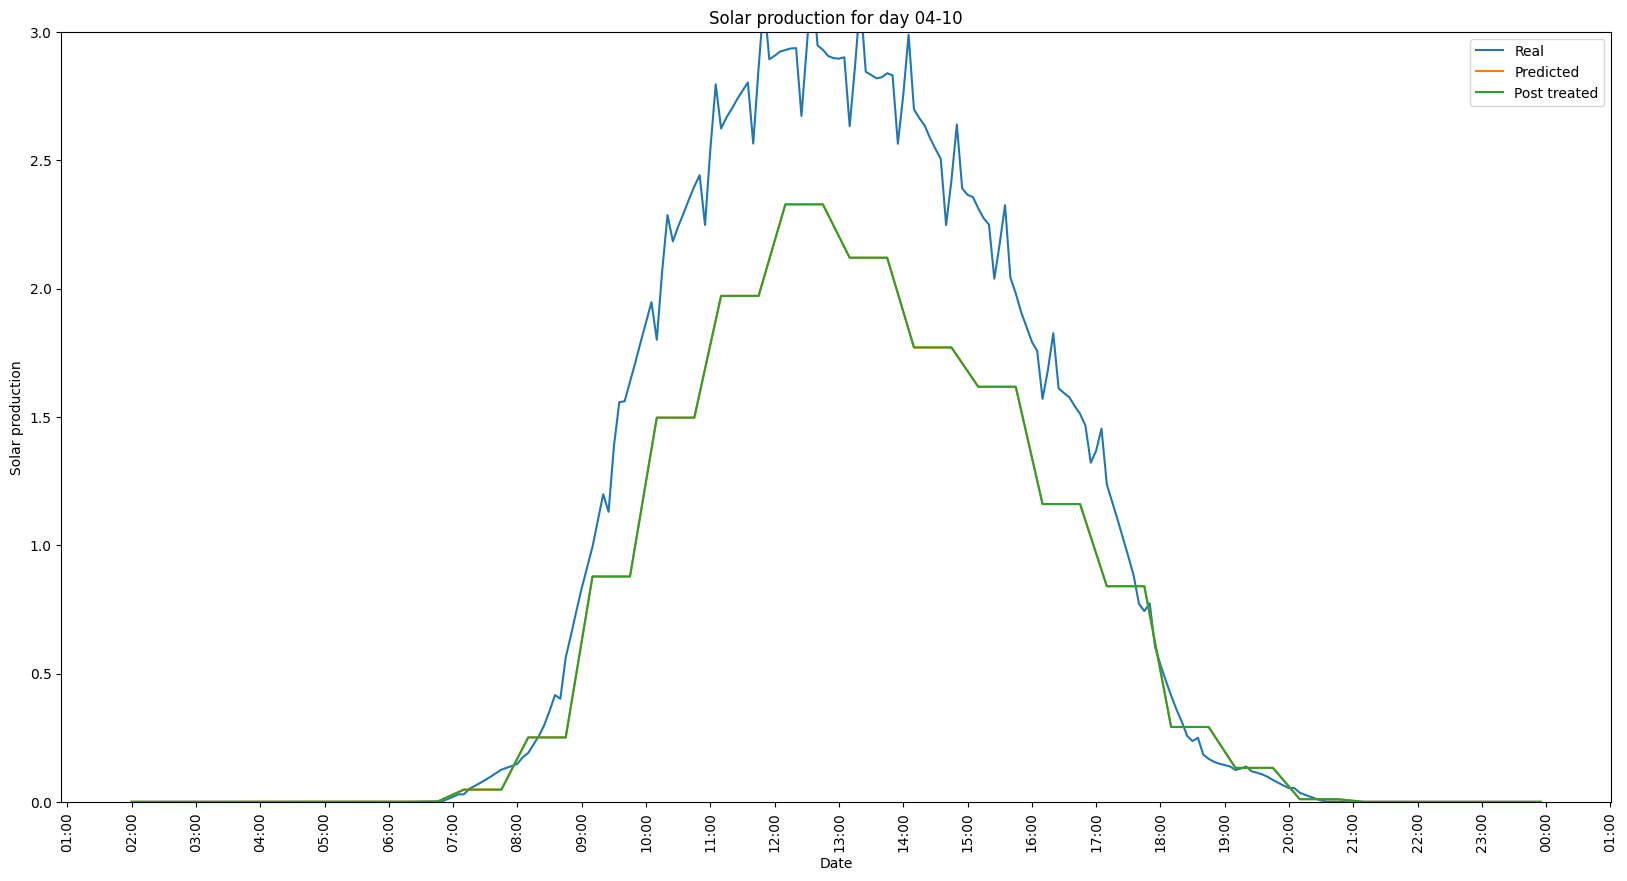

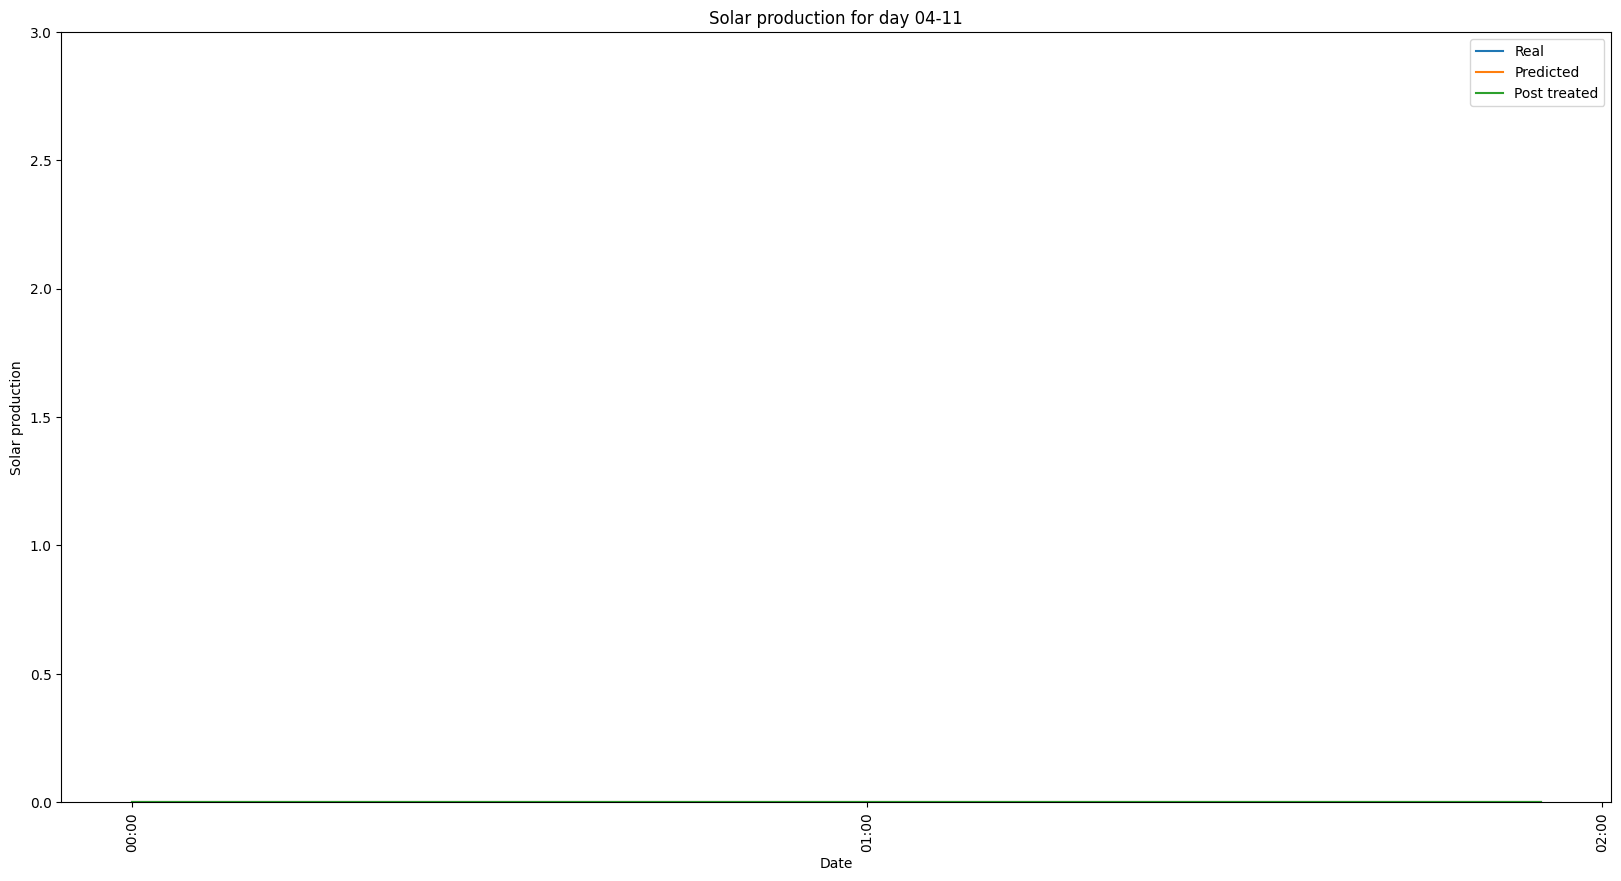

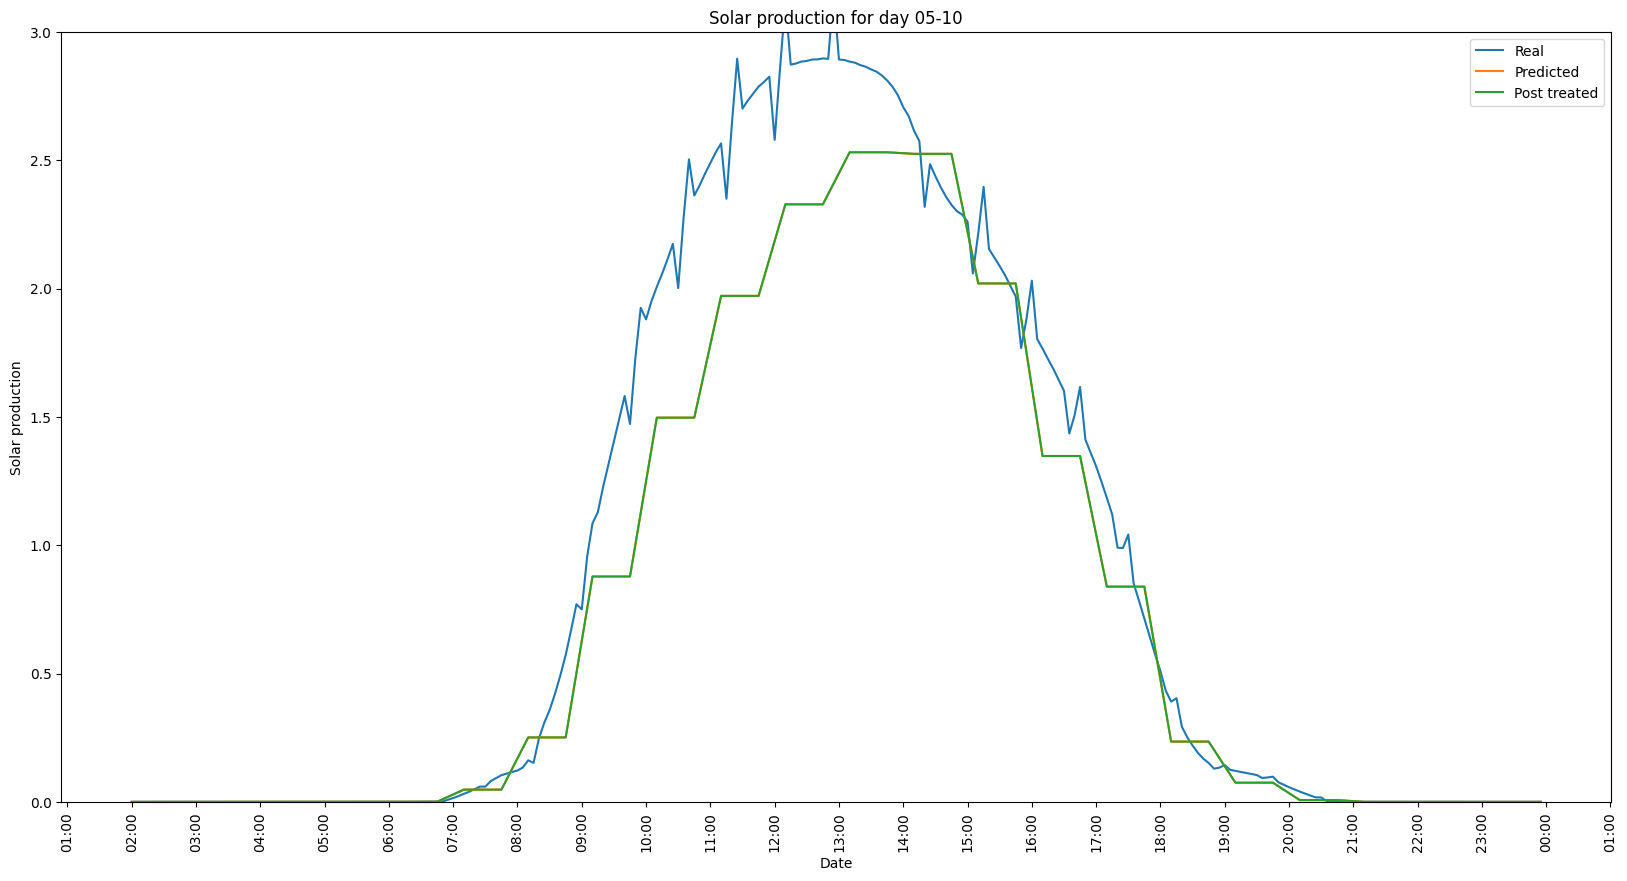

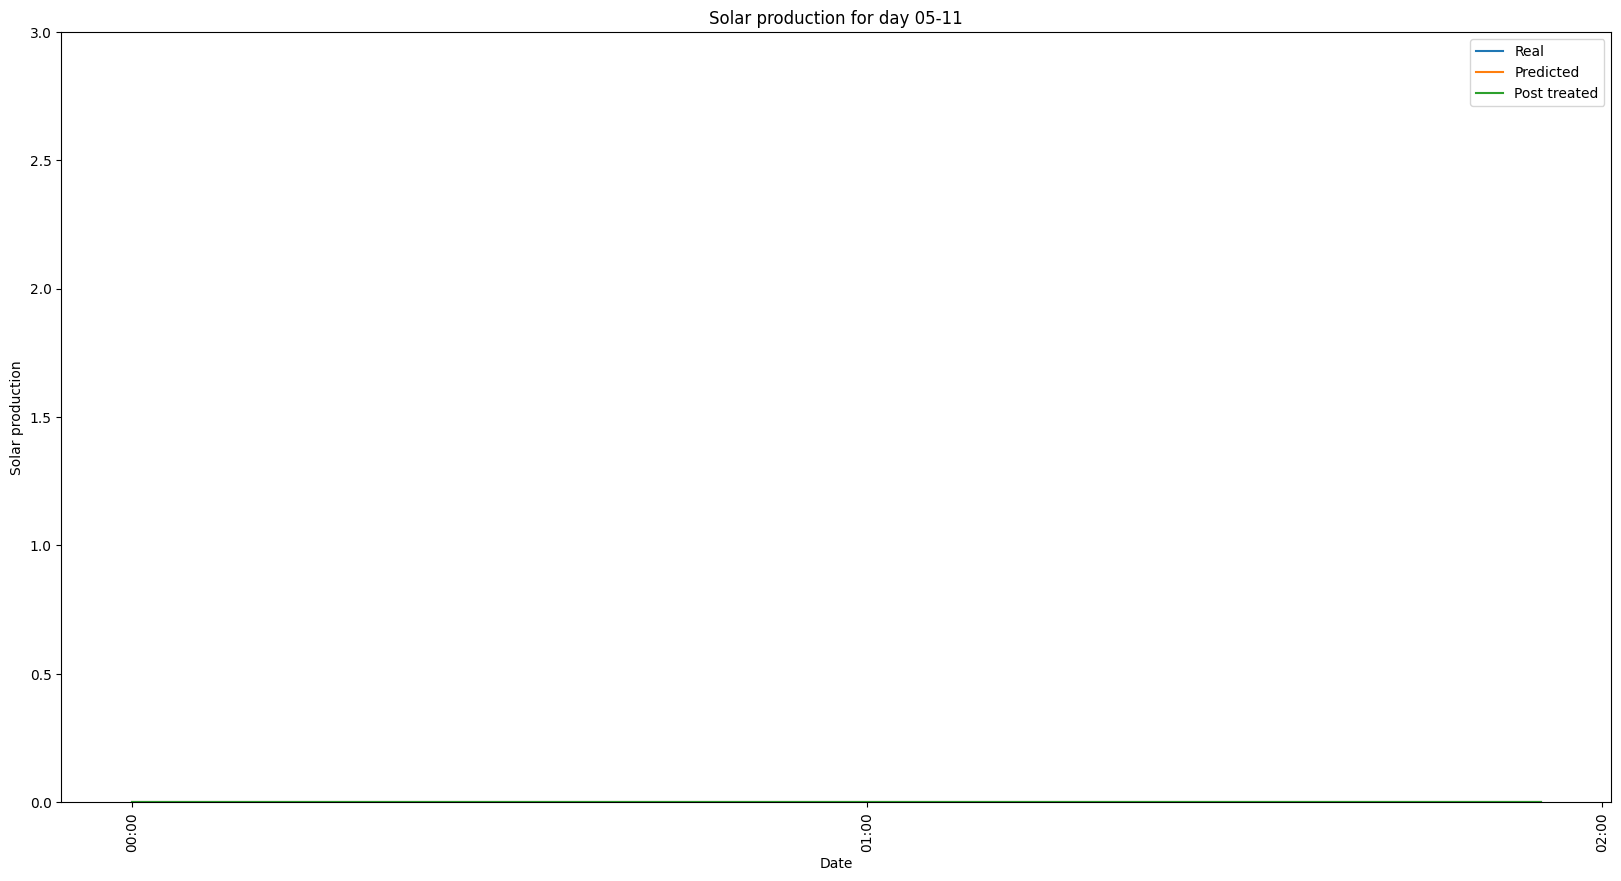

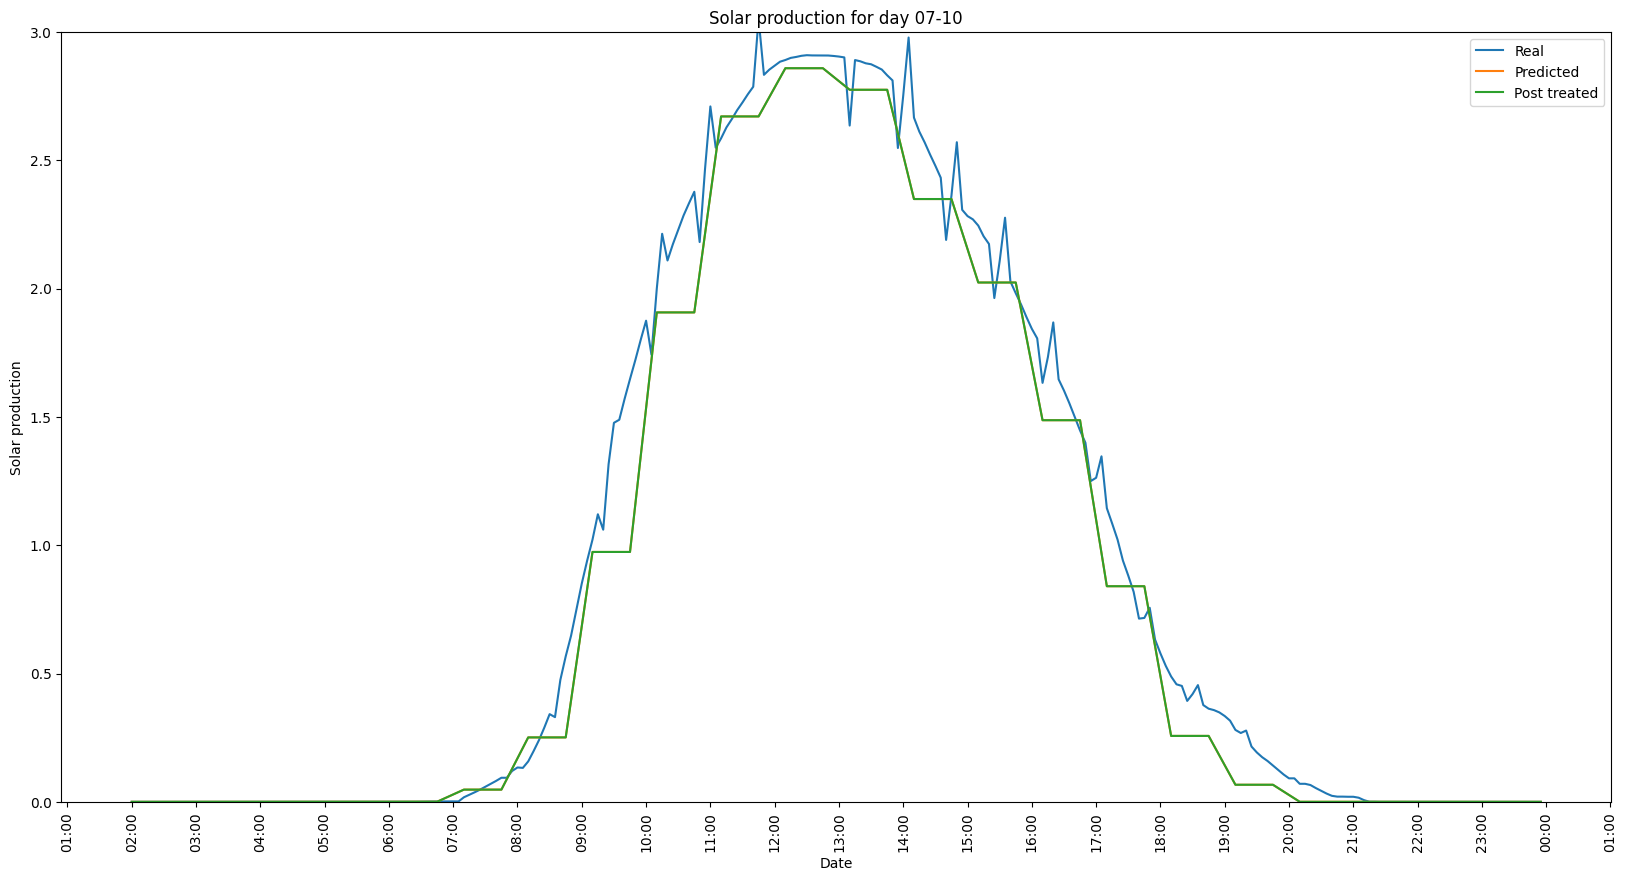

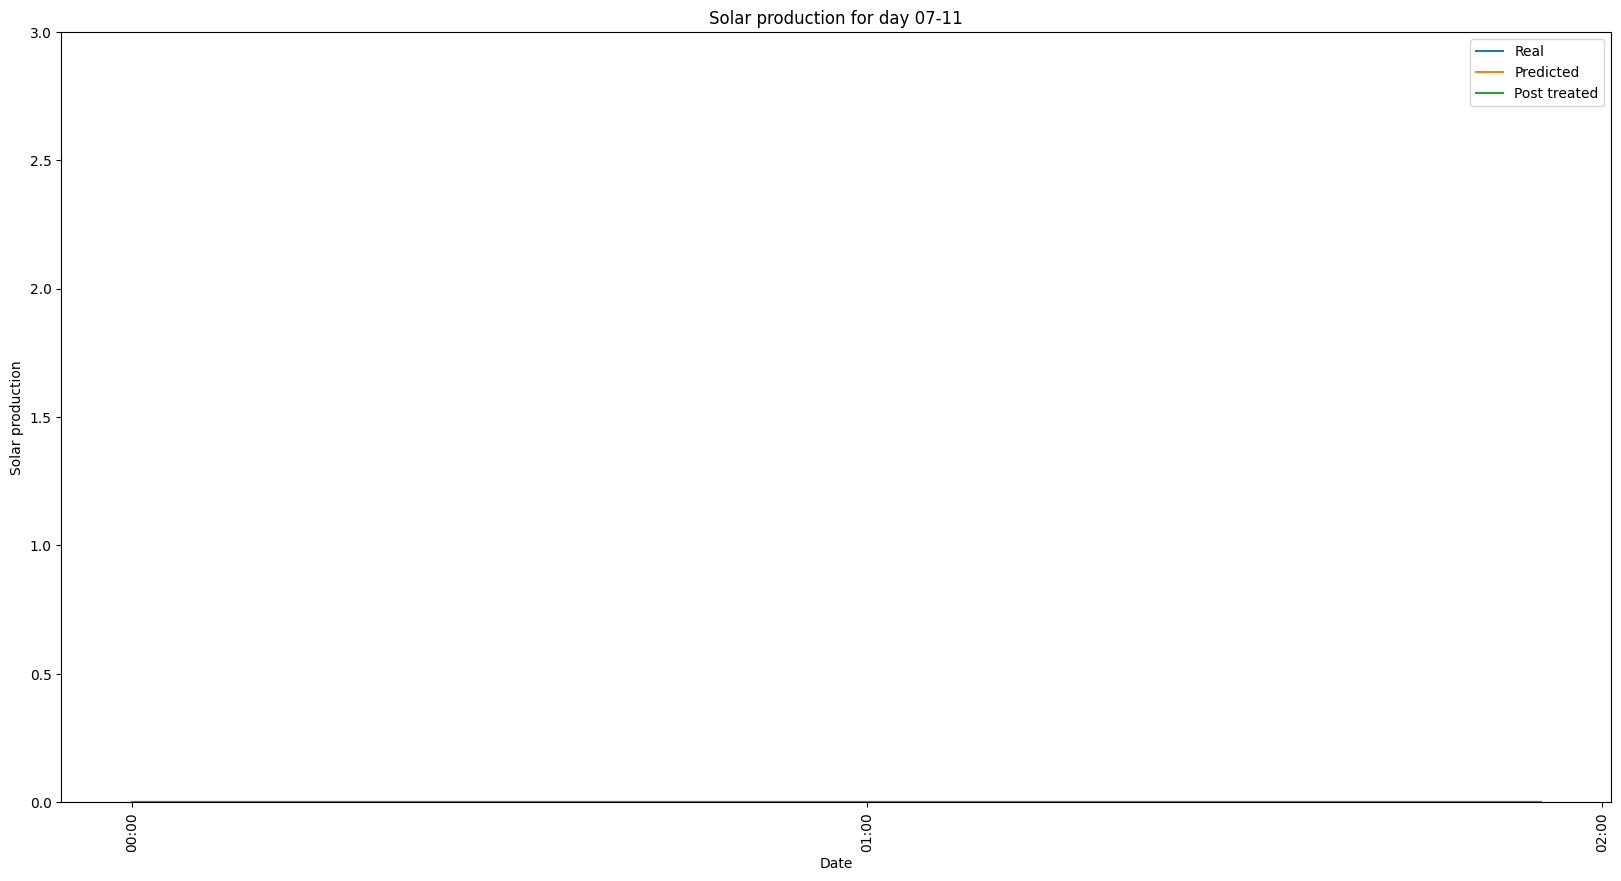

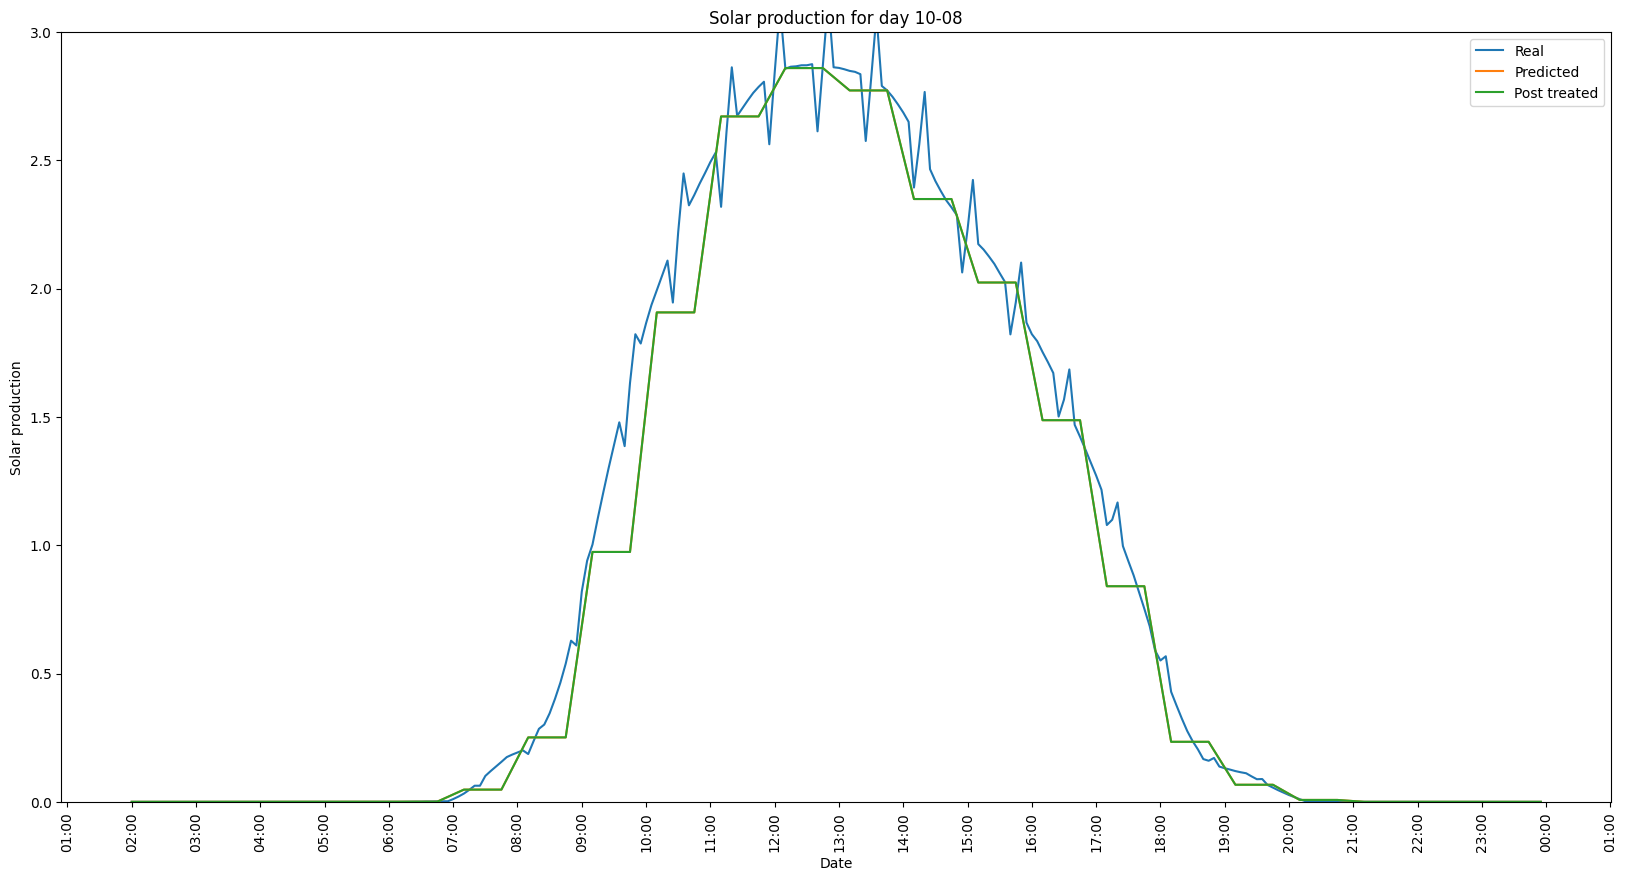

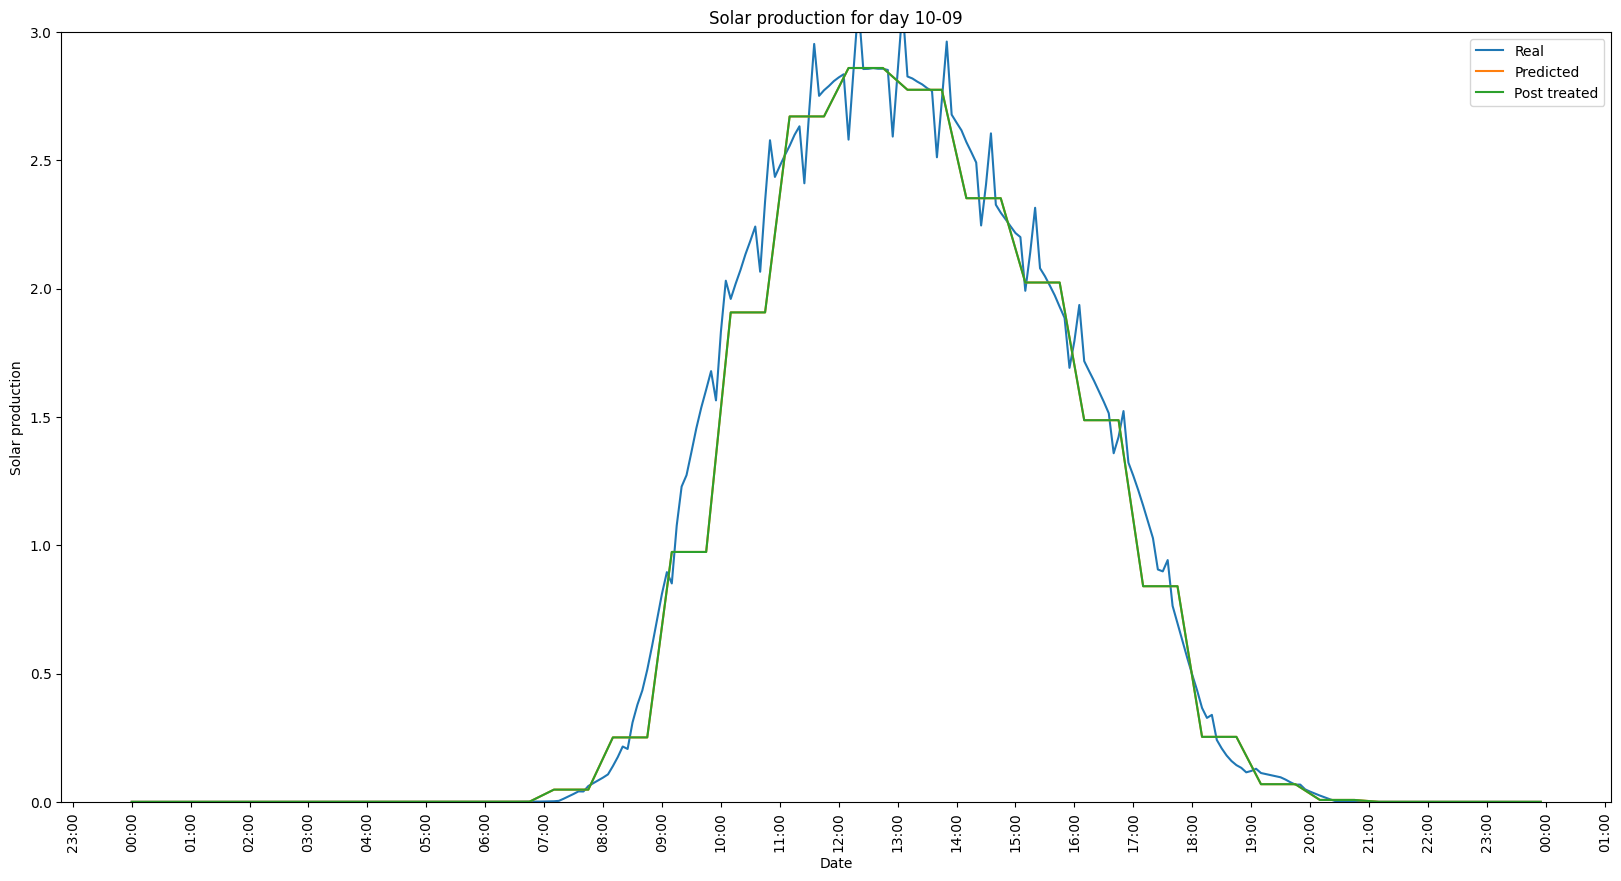

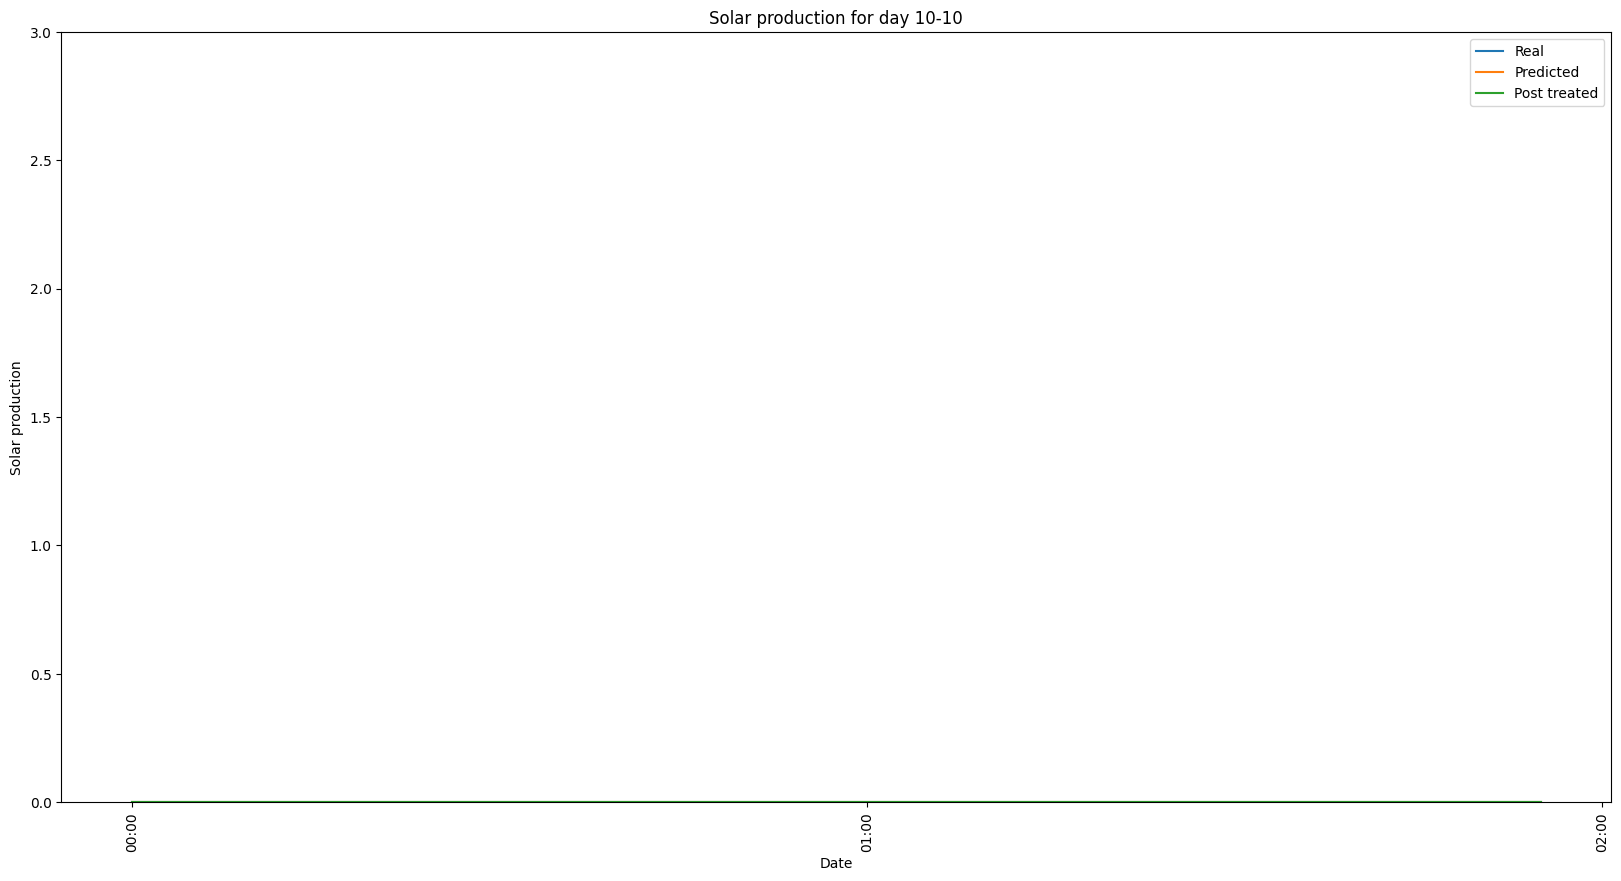

In [63]:
def smooth_results(predicted: pd.DataFrame):
    # Smooth the results with numpy.convolve
    predicted['predicted'] = np.convolve(predicted['predicted'], np.ones((5,)) / 5, mode='same')
    return predicted


def plot_compare(real, predicted, post_treated):

    original = pd.read_csv("dataset/test_students.csv")
    original['Date'] = pd.to_datetime(original['Date'], format='%Y-%d-%m %H:%M:%S')


    # Append date to every prediction
    real['Date'] = original['Date']
    predicted['Date'] = original['Date']
    post_treated['Date'] = original['Date']

    uniqueDayMonth = original['Date'].dt.strftime('%d-%m').unique()

    for dm in uniqueDayMonth:
        dayMonthDf = original[original['Date'].dt.strftime('%d-%m') == dm]

        if real['solar_production'].max() < 0.2 \
                and predicted['predicted'].max() < 0.2 \
                and post_treated['predicted'].max() < 0.2:
            continue

        # Create figure 20 x 15
        fig, ax = plt.subplots(figsize=(20, 10))
        # Plot the data of 4 different predictions
        ax.plot(dayMonthDf['Date'], real[real['Date'].dt.strftime('%d-%m') == dm]['solar_production'], label='Real')
        ax.plot(dayMonthDf['Date'], predicted[predicted['Date'].dt.strftime('%d-%m') == dm]['predicted'], label='Predicted')
        ax.plot(dayMonthDf['Date'], post_treated[post_treated['Date'].dt.strftime('%d-%m') == dm]['predicted'], label='Post treated')

        # Label the axes
        ax.set(xlabel="Date", ylabel="Solar production", title="Solar production for day " + str(dm))
        # Add legend
        ax.legend()

        # Set X Major ticks DayLocator
        ax.xaxis.set_major_locator(mdates.HourLocator())
        # Set X Major ticks format
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        # Set Y Axis limit = 3
        ax.set_ylim(0, 3)

        # Set X major ticks rotation
        plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
        # Set X minor ticks rotation
        plt.setp(ax.get_xticklabels(minor=True), rotation=90, ha="center")

        # Show figure
        plt.show()


real = df_cleaned['solar_production'].to_frame()
predicted = pd.DataFrame(estimator.predict(df_cleaned.drop(columns=['solar_production'])), columns=['predicted'])
post_treated = pd.DataFrame(smooth_results(predicted), columns=['predicted'])

plot_compare(real, predicted, post_treated)

Le post traitement n'a pas vraiment d'effet sur la prédiction.